Esercizio

MAPPA BASATA SU LANDMARK

BREVE RIPASSO SUI FILTRI PARTICELLARI

Il filtro particellare è utilizzato con mappe basate su feature (landmark) o con mappe della griglia di occupazione.

In particolare, il filtro particellare rappresenta la stima della posizione del robot attraverso un insieme di particelle. Ogni singola particella ha una credenza indipendente, in quanto mantiene la posa e una serie di landmark per n landmark (x,y,θ).

Le particelle sono inizialmente tratte da una distribuzione uniforme rappresentando l'incertezza iniziale. I passi sono i seguenti:

a. Prevedere la posa per ogni particella usando il modello del moto

b. Aggiornare le particelle con osservazioni, dove i pesi sono regolati in base alla probabilità che la particella abbia la corretta posa data la misurazione del sensore

c. Ricampionare in modo tale che le particelle con i pesi maggiori vengano selezionati mentre quelli con i pesi più bassi vengano eliminati.

Per poter costruire la mappa basata su landmark vengono creati due file python :
- read_data = è il file python che implementa i metodi utili a leggere i file che contengono informazioni sulla mappa 
- particle_filter = è il file che viene eseguito e che richiama i metodi del file read_data

In particolare il file read_data definisce i metodi:
- read_world = legge la definizione del mondo e ritorna una lista di landmark, la nostra mappa. 
    Il dict ritornato contiene una lista di landmarks, ognuno con le leguenti informazioni: {id, [x, y]}.

- read_sensor_data = legge l'odometria e le informazioni sensoriali dal file.
    Il dato è immagazzinato in un dict dove u_t e z_t sono memorizzati insieme come segue : {odometry,sensor}
    dove
    - "odometry" ha i campi r1, r2, t i quali contengono i valori delle variabili del modello del moto
    - "sensor" è una lista di misurazioni sensoriali con id, range e bearing come valori.

In [3]:
def read_world(filename):

    landmarks = dict()

    f = open(filename) 
    
    for line in f:

        line_s  = line.split('\n')    
        line_spl  = line_s[0].split(' ')
        landmarks[int(line_spl[0])] = [float(line_spl[1]),float(line_spl[2])]      

    return landmarks

def read_sensor_data(filename):
   
    # The odometry and sensor values are accessed as follows:
    # odometry_data = sensor_readings[timestep, 'odometry']
    # sensor_data = sensor_readings[timestep, 'sensor']

    sensor_readings = dict()

    lm_ids =[]
    ranges=[]
    bearings=[]

    first_time = True
    timestamp = 0
    f = open(filename)

    for line in f:
        
        line_s = line.split('\n') # remove the new line character
        line_spl = line_s[0].split(' ') # split the line
        
        if (line_spl[0]=='ODOMETRY'):
            
            sensor_readings[timestamp,'odometry'] = {'r1':float(line_spl[1]),'t':float(line_spl[2]),'r2':float(line_spl[3])}
            
            if first_time: 
                first_time = False
                
            else: 
                sensor_readings[timestamp,'sensor'] = {'id':lm_ids,'range':ranges,'bearing':bearings}                
                lm_ids=[]
                ranges = []
                bearings = []

            timestamp = timestamp+1
           
        if(line_spl[0]=='SENSOR'):
            
            lm_ids.append(int(line_spl[1]))    
            ranges.append(float(line_spl[2]))
            bearings.append(float(line_spl[3]))
                              
        sensor_readings[timestamp-1,'sensor'] = {'id':lm_ids,'range':ranges,'bearing':bearings}            
    
    return sensor_readings

Nel file particle_filter vengono importate le seguenti librerie

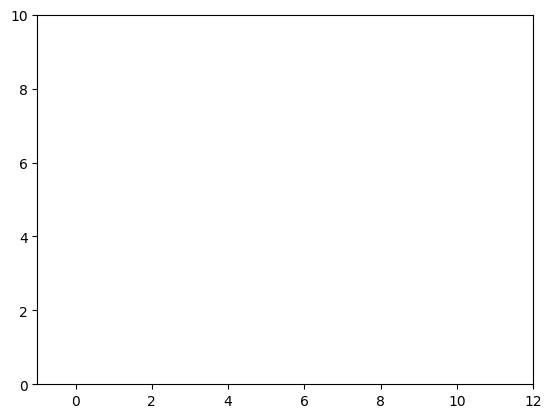

In [4]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
#from read_data import read_world, read_sensor_data

#add random seed for generating comparable pseudo random numbers
np.random.seed(123)

#plot preferences, interactive plotting mode
plt.axis([-1, 12, 0, 10]) #asse x da -1 a 12 e asse y da 0 a 10
plt.ion()
plt.show()


Viene definito il metodo initialize_particles per inizializzare le particelle nei limiti della mappa.

In [5]:
def initialize_particles(num_particles, map_limits):
    # randomly initialize the particles inside the map limits

    particles = []

    for i in range(num_particles):
        particle = dict()

        # draw x,y and theta coordinate from uniform distribution
        # inside map limits
        particle['x'] = np.random.uniform(map_limits[0], map_limits[1])
        particle['y'] = np.random.uniform(map_limits[2], map_limits[3])
        particle['theta'] = np.random.uniform(-np.pi, np.pi)

        particles.append(particle)

    return particles


Viene definito il metodo plot_state per visualizzare lo stato del filtro particellare.

In particolare visualizza il cloud di particelle, la posizione media e i landmarks.

Per la posizione media è stato definito il metodo mean_pose. La posizione media è la media delle coordinate.

In [6]:
def mean_pose(particles):
   

    # save x and y coordinates of particles
    xs = []
    ys = []

    # save unit vectors corresponding to particle orientations 
    vxs_theta = []
    vys_theta = []

    for particle in particles:
        xs.append(particle['x'])
        ys.append(particle['y'])

        #make unit vector from particle orientation
        vxs_theta.append(np.cos(particle['theta']))
        vys_theta.append(np.sin(particle['theta']))

    #calculate average coordinates
    mean_x = np.mean(xs)
    mean_y = np.mean(ys)
    mean_theta = np.arctan2(np.mean(vys_theta), np.mean(vxs_theta))

    return [mean_x, mean_y, mean_theta]

def plot_state(particles, landmarks, map_limits):
   
    
    xs = []
    ys = []

    for particle in particles: #scorro tutte le particelle e riempio xs e ys
        xs.append(particle['x'])
        ys.append(particle['y'])

    # landmark positions
    lx=[]
    ly=[]

    #Stesso discorso per i landmarks, cioè li scorro e li appendo in lx e in ly
    for i in range (len(landmarks)):
        lx.append(landmarks[i+1][0])
        ly.append(landmarks[i+1][1])

    # mean pose as current estimate
    estimated_pose = mean_pose(particles)

    # plot filter state
    plt.clf()
    plt.plot(xs, ys, 'r.')
    plt.plot(lx, ly, 'bo',markersize=10)
    plt.quiver(estimated_pose[0], estimated_pose[1], np.cos(estimated_pose[2]), np.sin(estimated_pose[2]), angles='xy',scale_units='xy')
    plt.axis(map_limits)

    plt.pause(0.01)

Viene definito il metodo sample_motion_model che campiona nuove particelle, calcola la posizione della nuova particella, tenendo conto della vecchia posizione, delle misure odomentriche deltarot1, deltaTrans, deltarot2 e del rumore del moto

In [7]:
def sample_motion_model(odometry, particles):
    # Samples new particle positions, based on old positions, the odometry
    # measurements and the motion noise 
    # (probabilistic motion models slide 27)

     #DEFINIAMO MISURE ODOMETRICHE TUTTE QUELLE MISURE OTTENUTE MEDIANTE I SENSORI
    
    delta_rot1 = odometry['r1']
    delta_trans = odometry['t']
    delta_rot2 = odometry['r2']

    # the motion noise parameters: [alpha1, alpha2, alpha3, alpha4]
    noise = [0.1, 0.1, 0.05, 0.05]
    
    # standard deviations of motion noise
    sigma_delta_rot1 = noise[0] * abs(delta_rot1) + noise[1] * delta_trans
    sigma_delta_trans = noise[2] * delta_trans + \
    noise[3] * (abs(delta_rot1) + abs(delta_rot2))
    sigma_delta_rot2 = noise[0] * abs(delta_rot2) + noise[1] * delta_trans

    #Generiamo un nuovo insieme di particelle, ottenute dopo l'update del movimento
    new_particles = []
    
    for particle in particles: 
        new_particle = dict(); #otteniamo un nuovo dizionario
        
        #Sample noisy motion 
        noisy_delta_rot1 = delta_rot1 + np.random.normal(0, sigma_delta_rot1)
        noisy_delta_trans = delta_trans + np.random.normal(0, sigma_delta_trans)
        noisy_delta_rot2 = delta_rot2 + np.random.normal(0, sigma_delta_rot2)
        
        
        # Calcolo la posizione della nuova particella, tenendo conto della vecchia posizione, delle
        #misure odomentrice deltarot1 e deltaTrans, deltarot2 e del noisemotion
        new_particle['x'] = particle['x'] + \
        noisy_delta_trans * np.cos(particle['theta'] + noisy_delta_rot1)
        new_particle['y'] = particle['y'] + \
        noisy_delta_trans * np.sin(particle['theta'] + noisy_delta_rot1)
        new_particle['theta'] = particle['theta'] + \
        noisy_delta_rot1 + noisy_delta_rot2
        new_particles.append(new_particle)
        
    return new_particles

Viene definito il metodo eval_sensor_model che calcola la probabilità di osservazione di tutte le particelle, date sia le posizioni delle particelle e dei landmark che le misure sensoriali. Definisce, quindi, i pesi di importanza delle particelle sulla base delle misure sensoriali.

In [8]:
def eval_sensor_model(sensor_data, particles, landmarks):


    sigma_r = 0.2

    #measured landmark ids and ranges
    ids = sensor_data['id']
    ranges = sensor_data['range']

    weights = []
    # weight each particle
    for particle in particles:
        all_meas_likelihood = 1.0
        # loop for each observed landmark
        for i in range(len(ids)):
            lm_id = ids[i]
            meas_range = ranges[i]
            lx = landmarks[lm_id][0]
            ly = landmarks[lm_id][1]
            px = particle['x']
            py = particle['y']  
            # calculate expected range measurement
            meas_range_exp = np.sqrt((lx - px) ** 2 + (ly - py) ** 2)
            # evaluate sensor model (probability density function of normal distribution)
            meas_likelihood = scipy.stats.norm.pdf(meas_range, meas_range_exp, sigma_r)
            # combine (independent) measurements
            all_meas_likelihood = all_meas_likelihood * meas_likelihood
        
        
        weights.append(all_meas_likelihood)
            # for combining multiple measurements

    #normalize weights
    normalizer = sum(weights)
    weights = weights / normalizer

    return weights

Viene definito il metodo resample_particles che restituisce il nuovo insieme di particelle basandosi sui pesi ad essi assegnati.

In [9]:
def resample_particles(particles, weights):

    new_particles = []
        # distance between pointers
    step = 1.0 / len(particles)
    # random start of first pointer
    u = np.random.uniform(0, step)
    # where we are along the weights
    c = weights[0]

    # index of weight container and corresponding particle
    i = 0
    new_particles = []
    # loop over all particle weights
    for particle in particles:
        # go through the weights until you find the particle
        # to which the pointer points
        while u > c:
            i = i + 1
            c = c + weights[i]
        # add that particle
        new_particles.append(particles[i])
        # increase the threshold
        u = u + step

    return new_particles

Per la simulzione viene definito il metodo main in cui si leggono i file world.dat e sensor_data.dat che contengono i dati relativi alla mappa(landmark) e le informazioni sensoriali. Tale metodo richiama i metodi utili per le varie fasi dell' esecuzione del filtro particellare.

Reading landmark positions
Reading sensor data


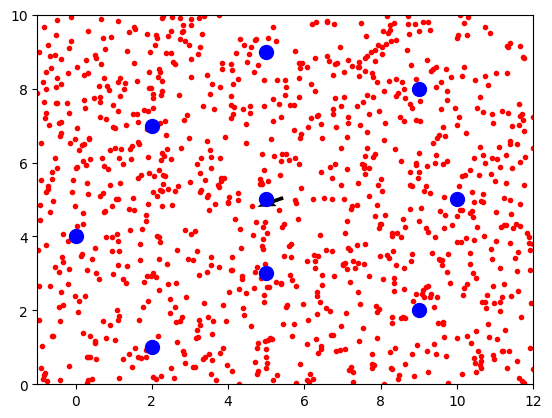

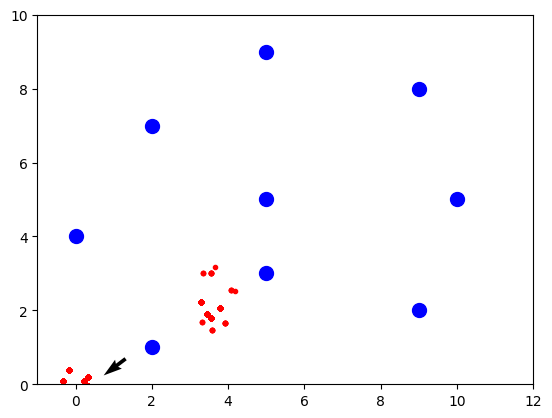

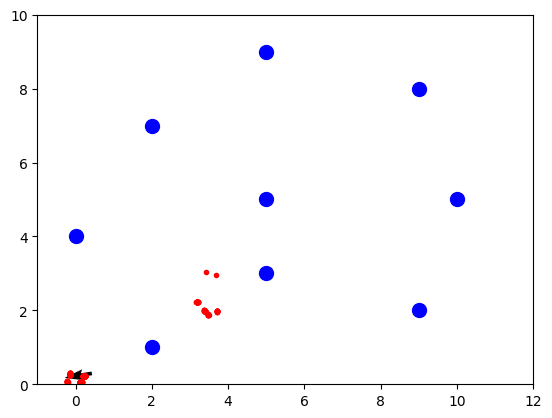

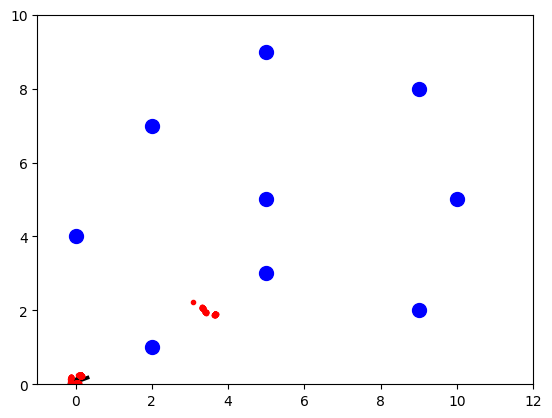

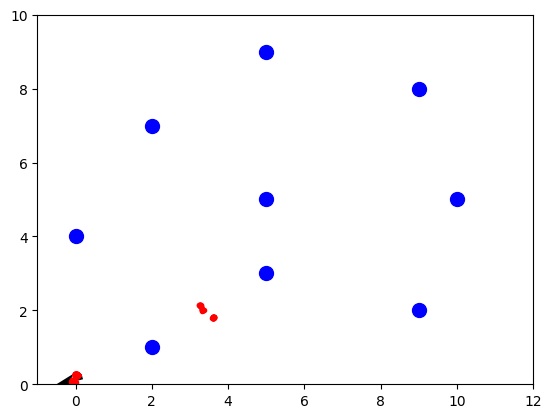

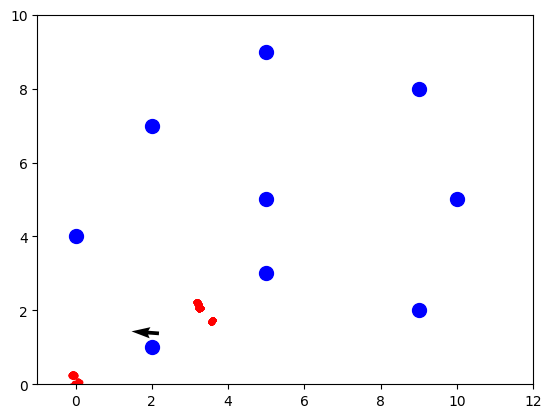

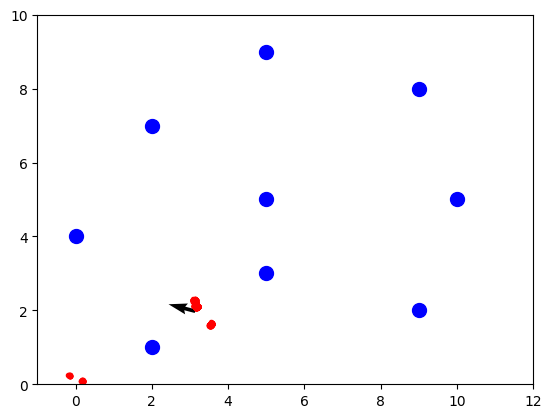

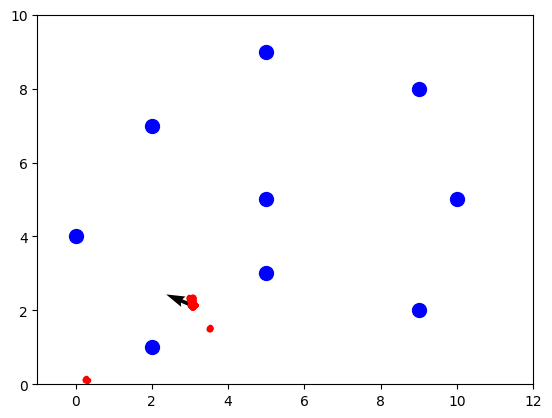

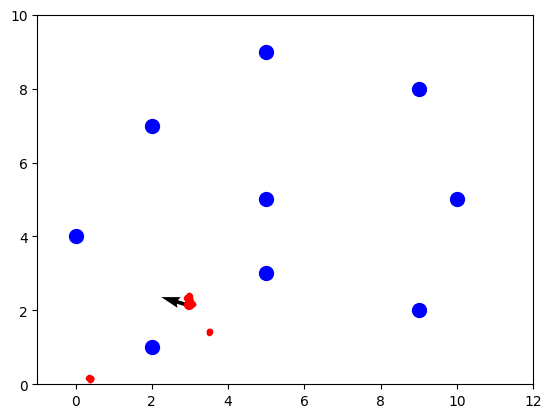

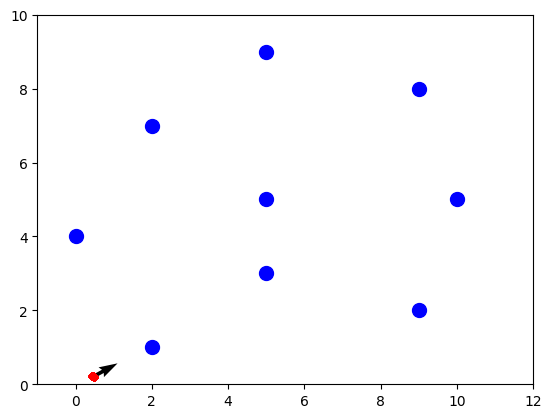

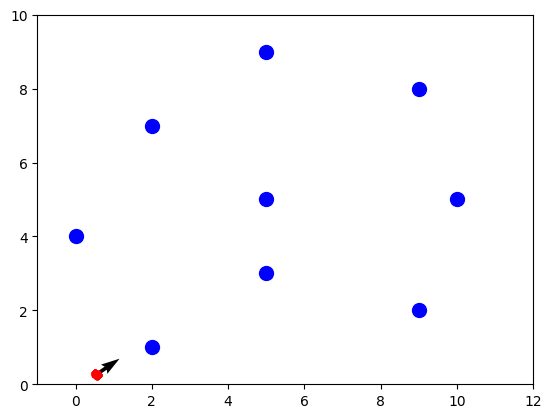

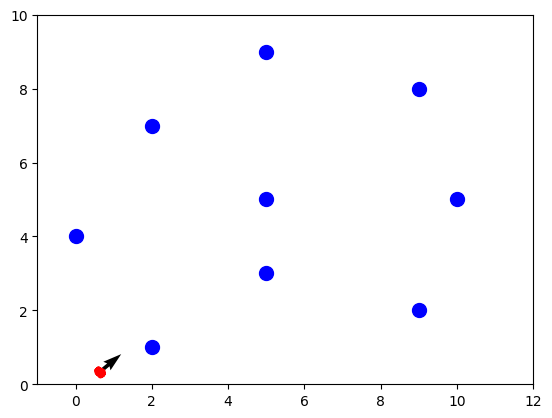

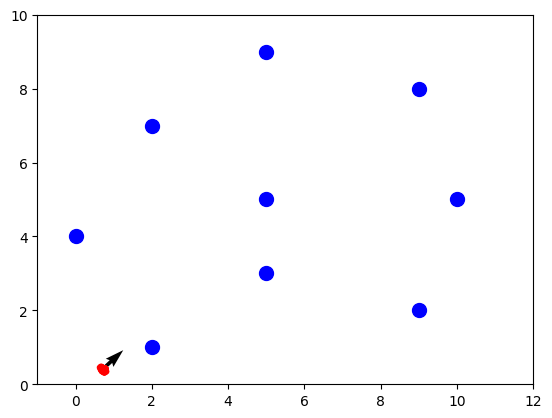

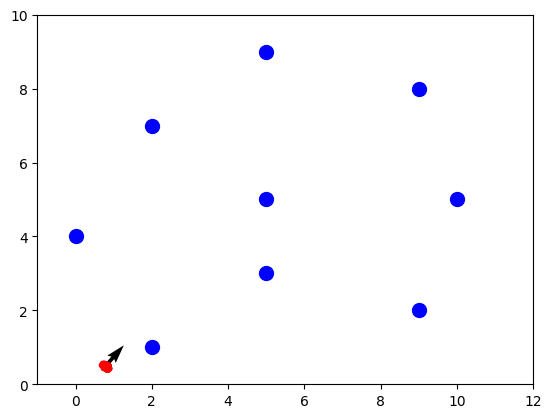

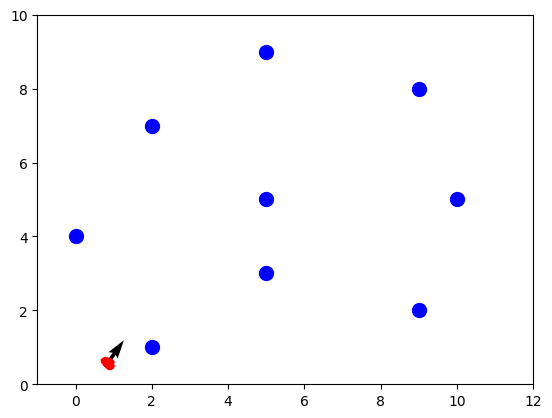

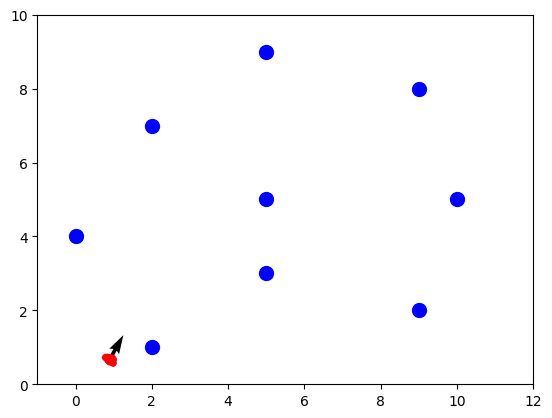

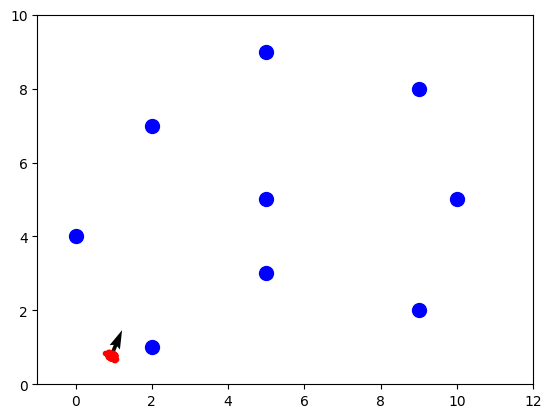

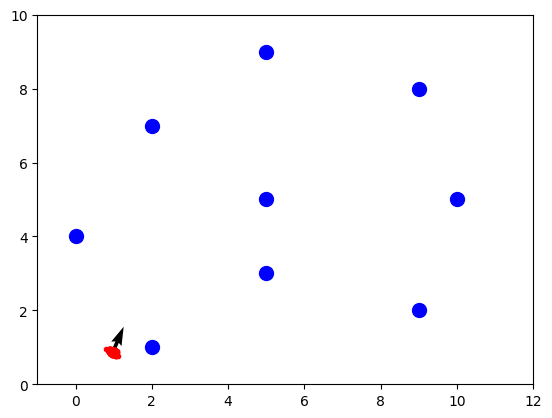

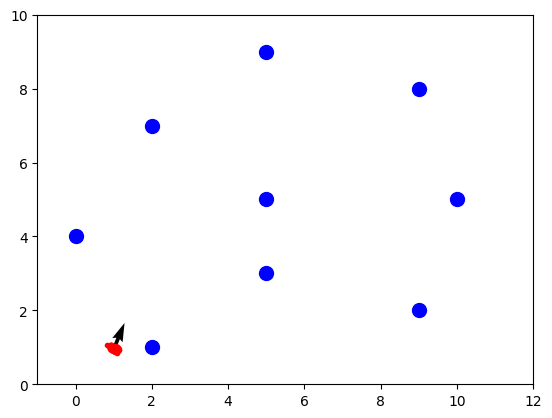

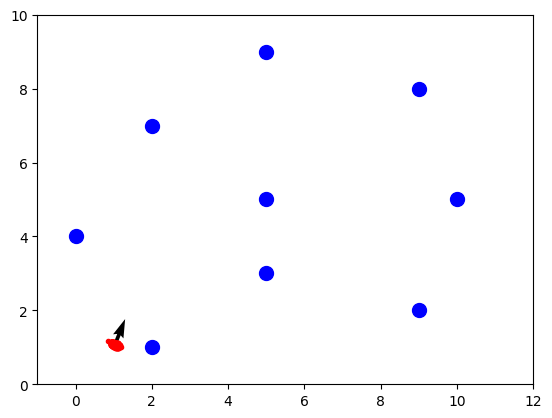

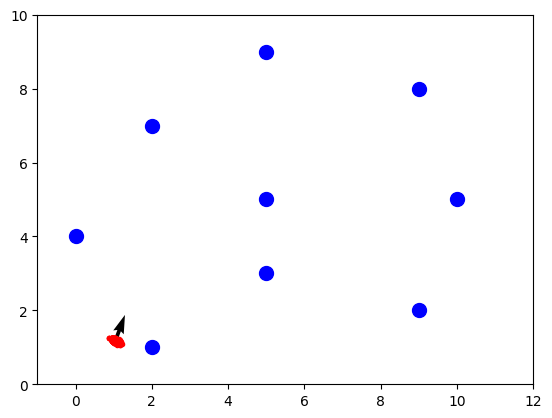

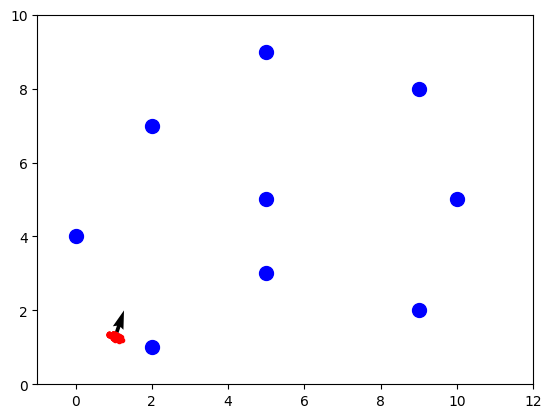

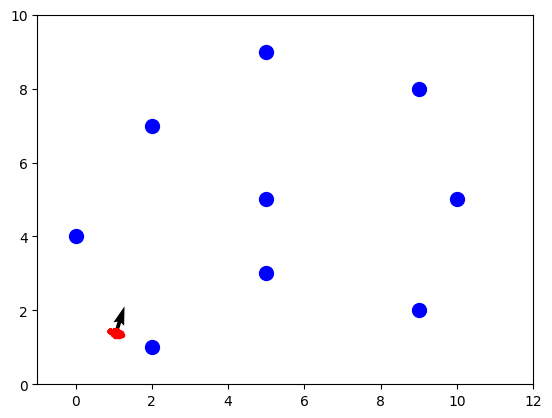

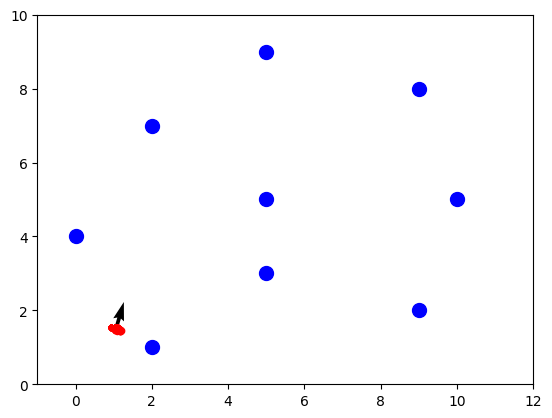

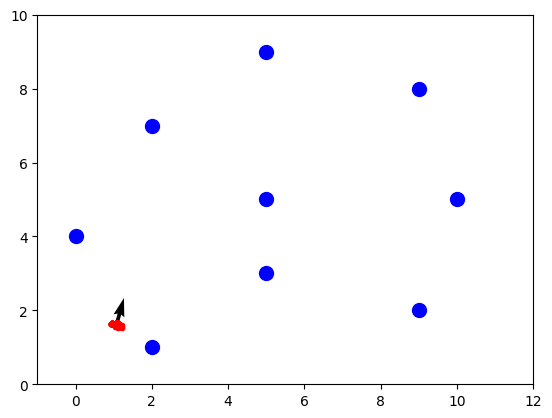

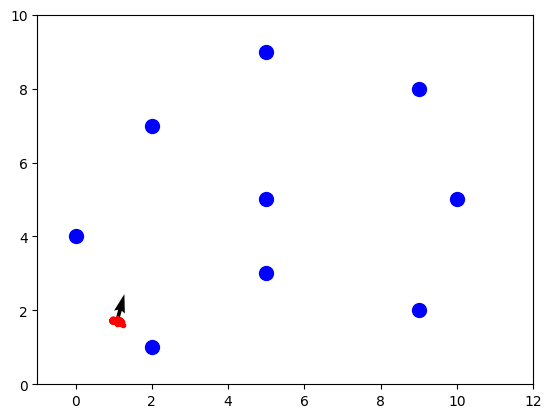

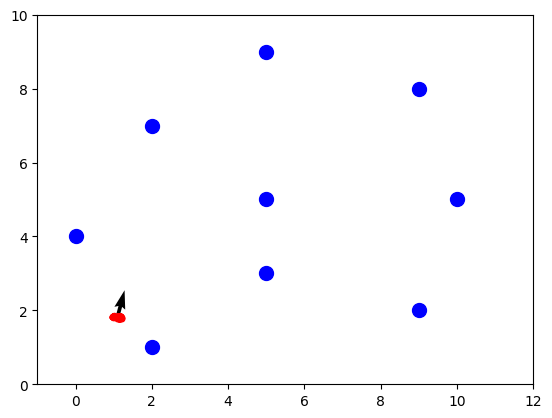

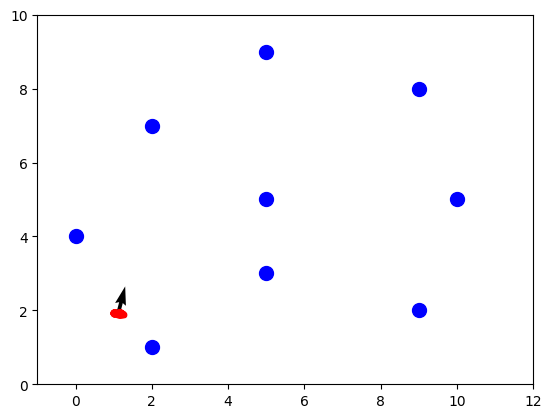

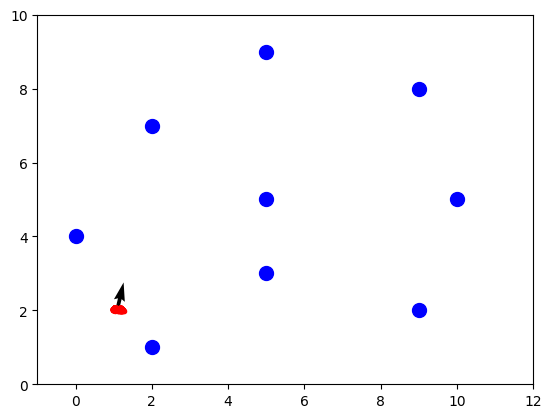

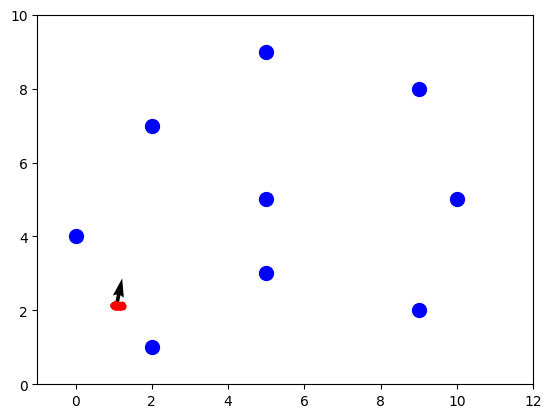

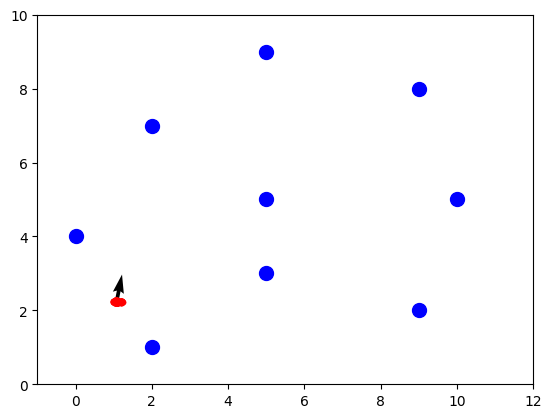

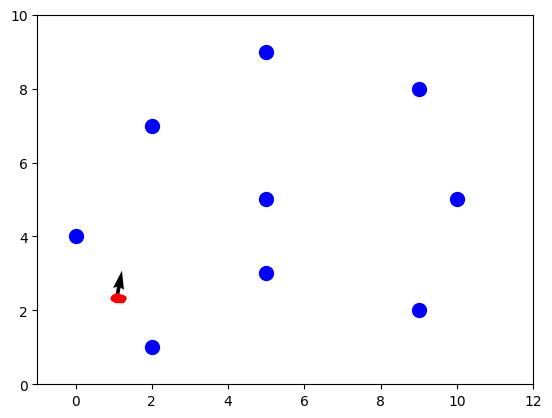

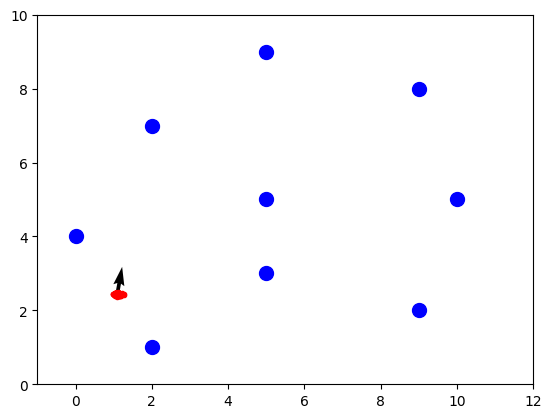

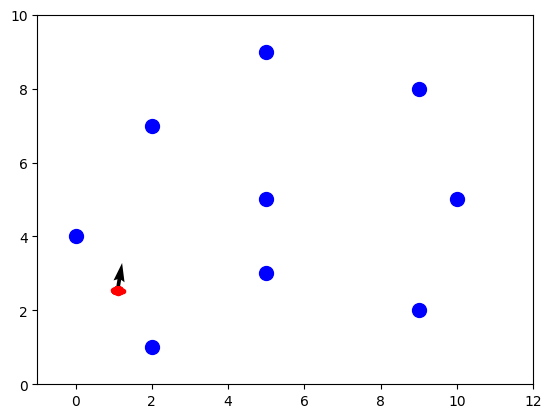

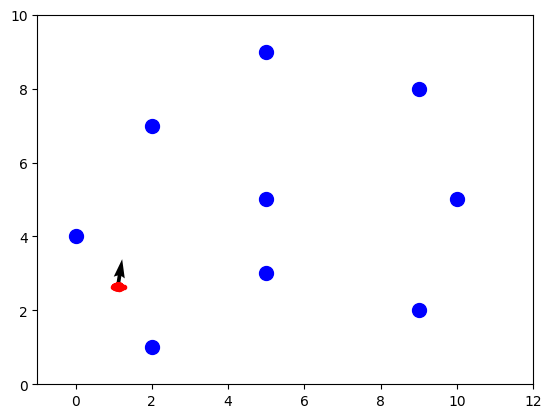

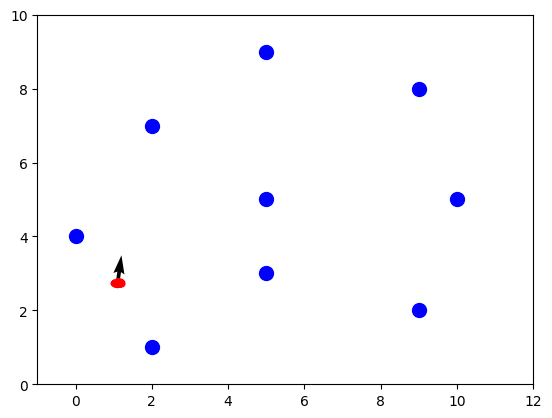

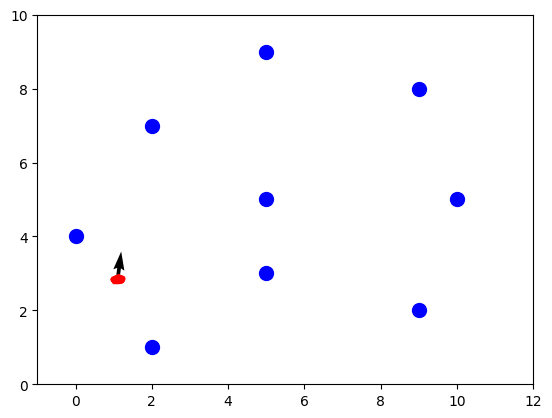

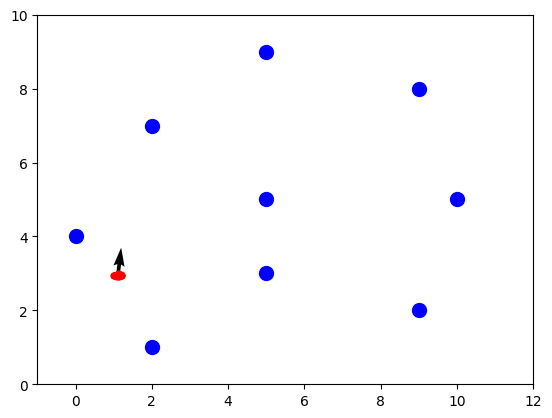

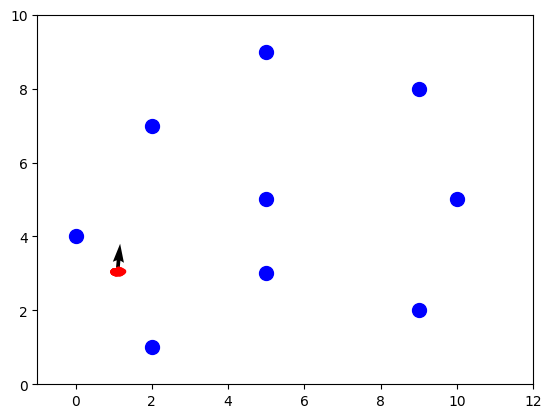

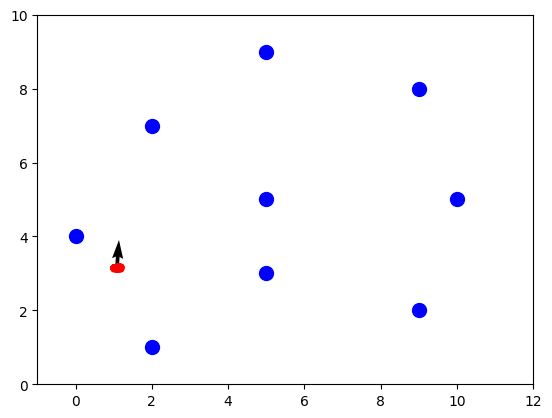

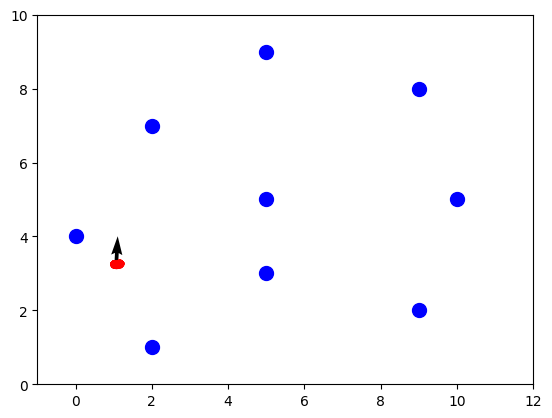

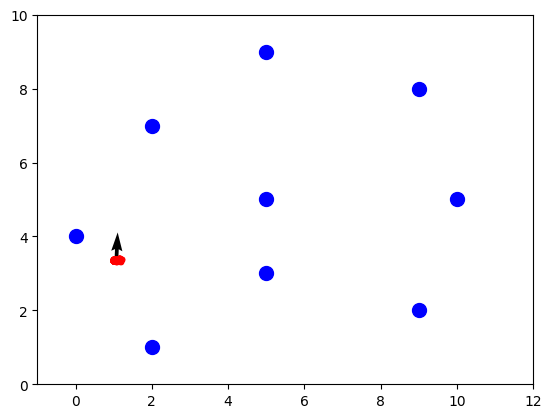

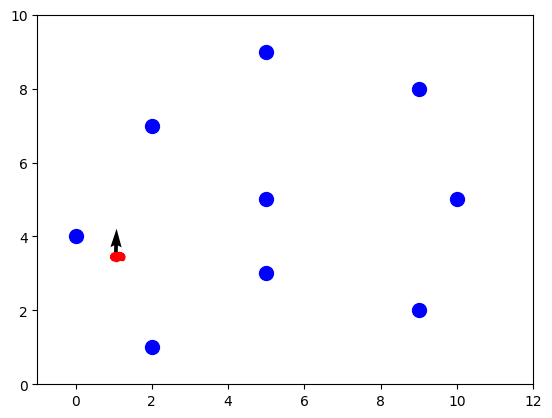

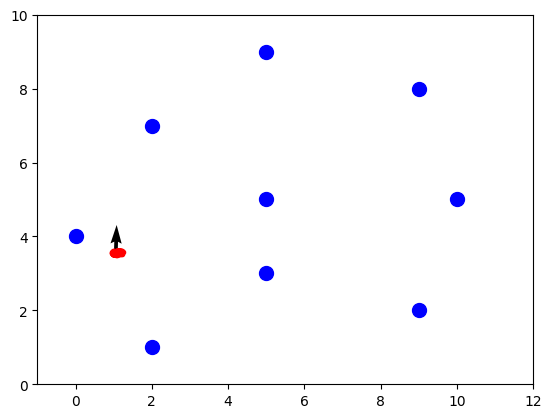

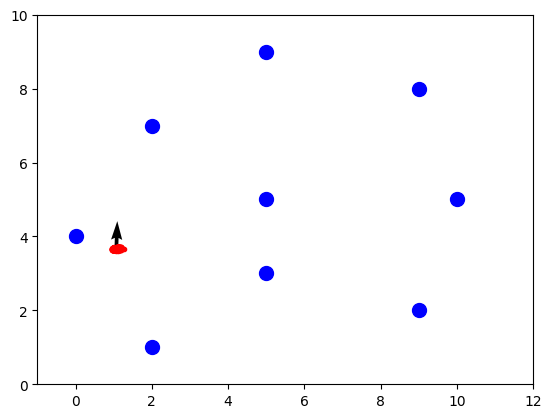

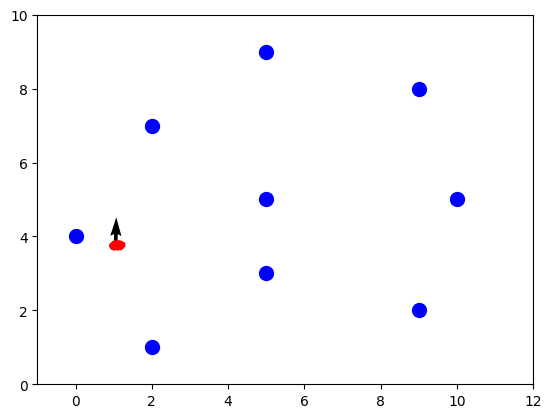

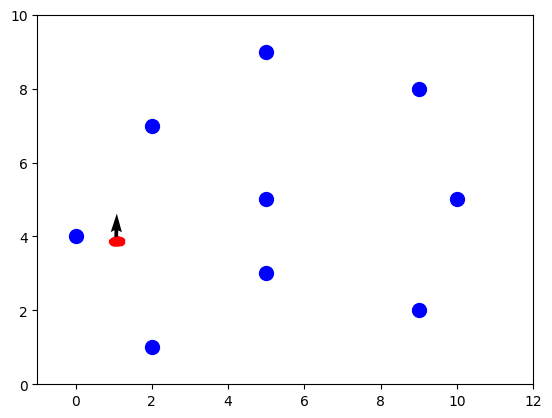

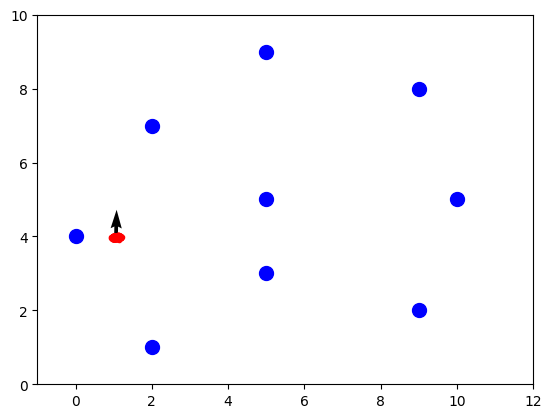

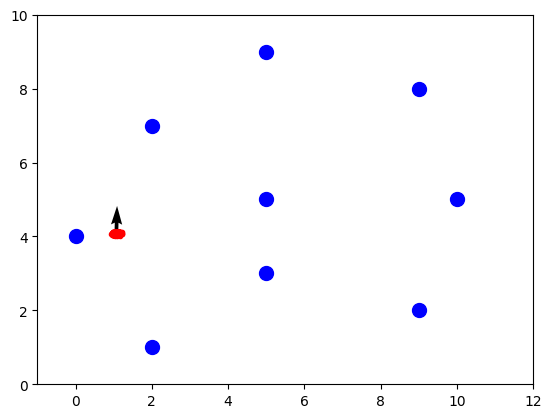

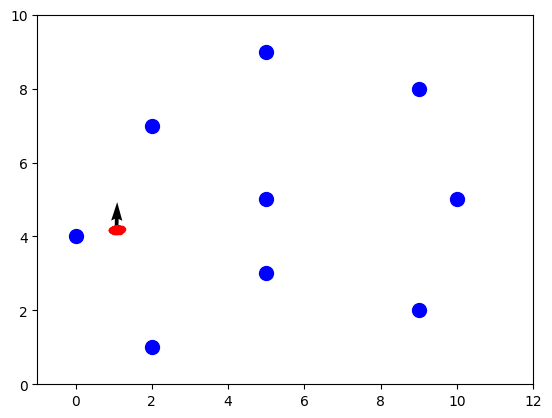

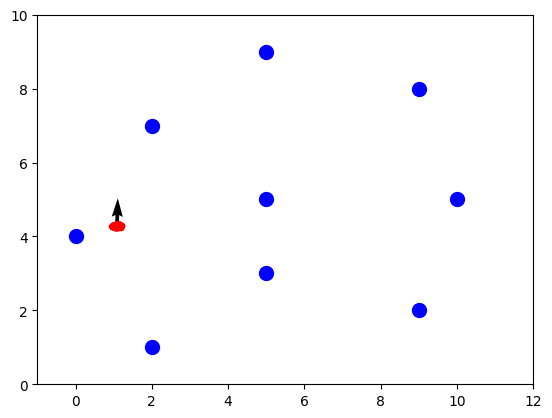

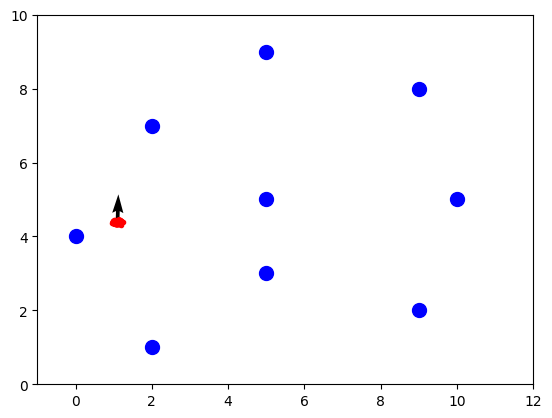

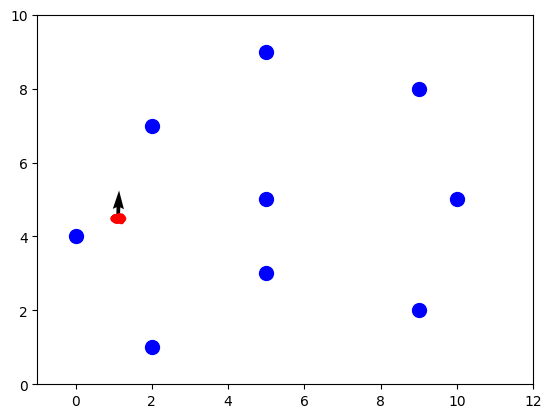

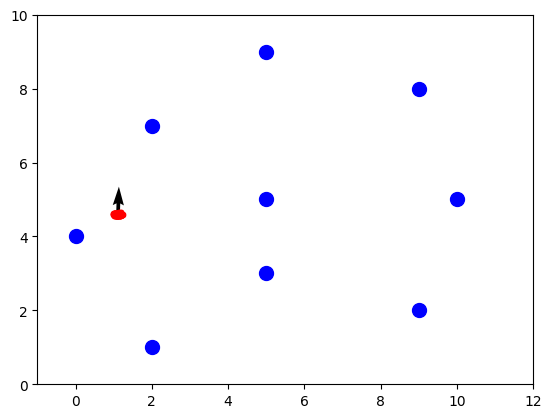

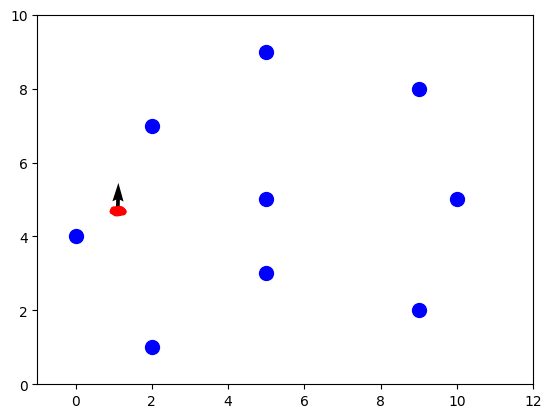

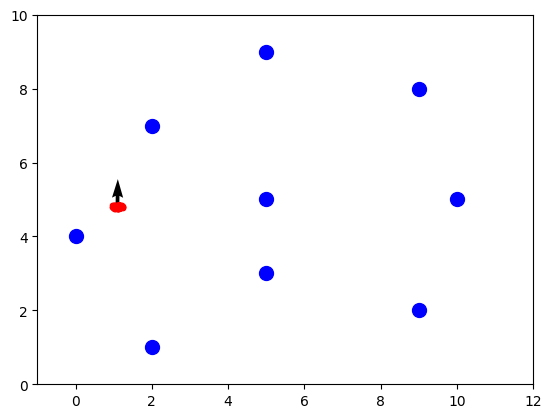

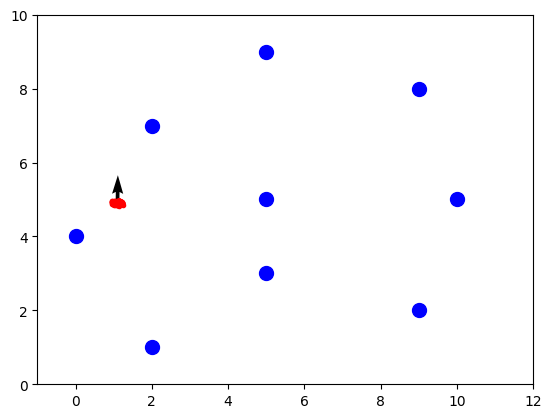

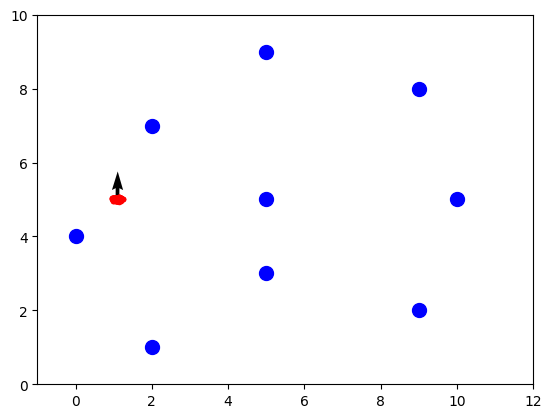

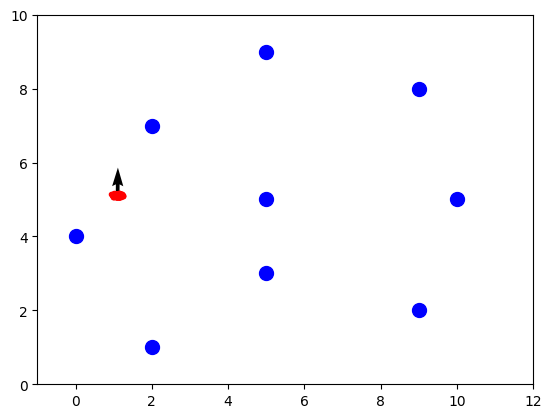

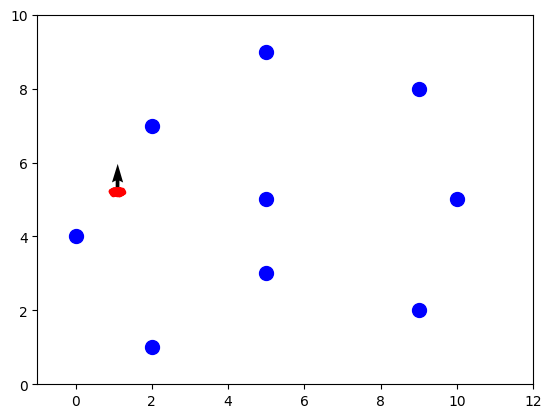

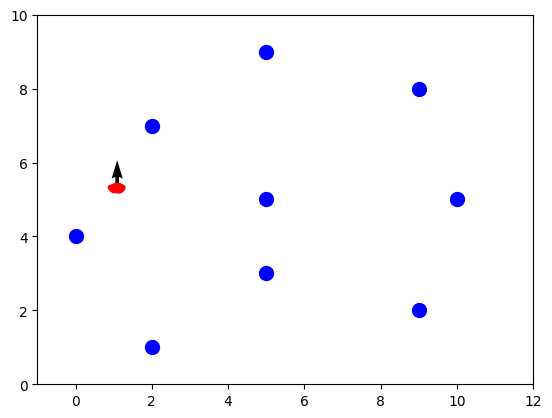

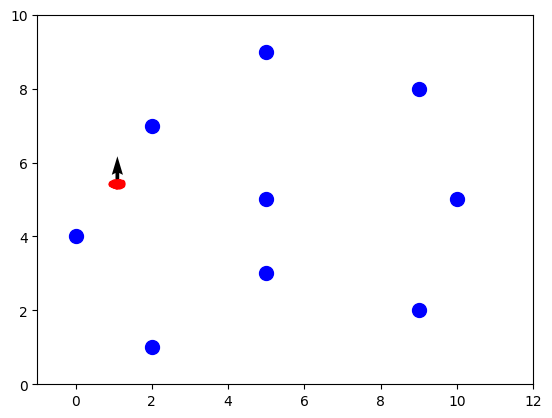

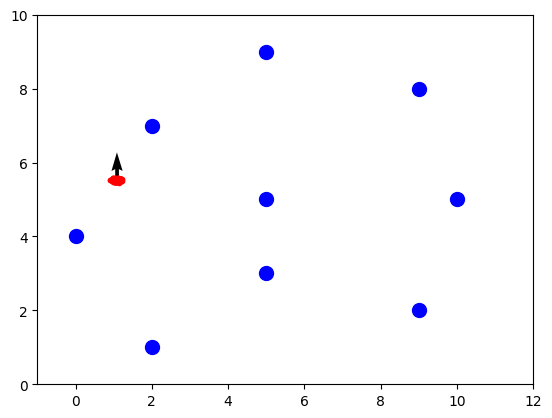

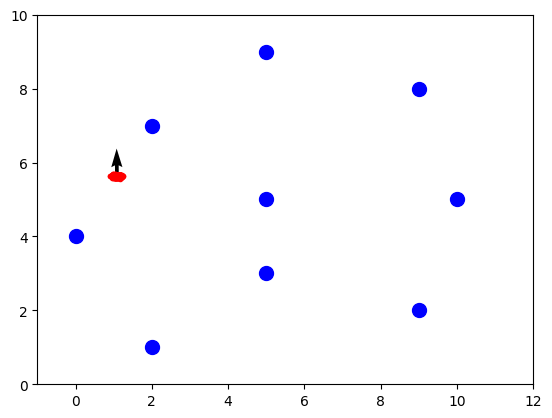

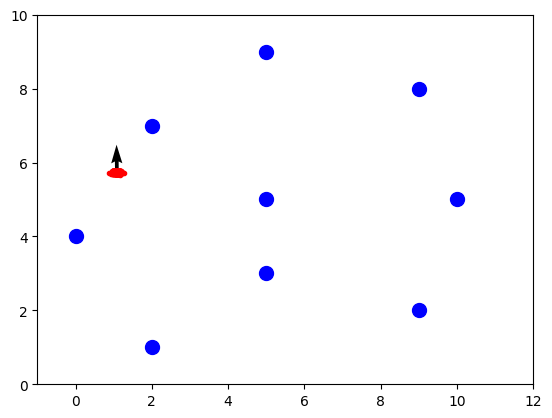

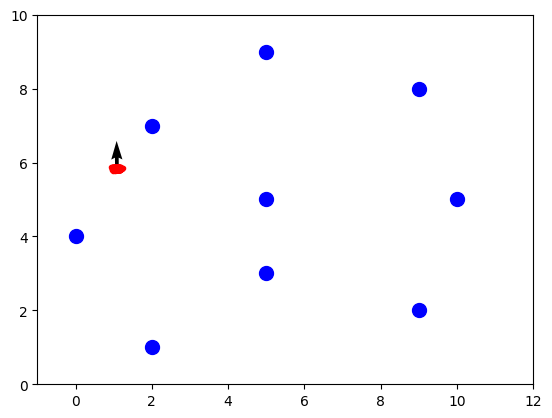

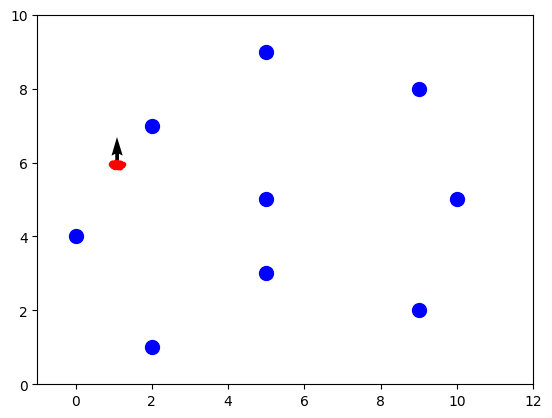

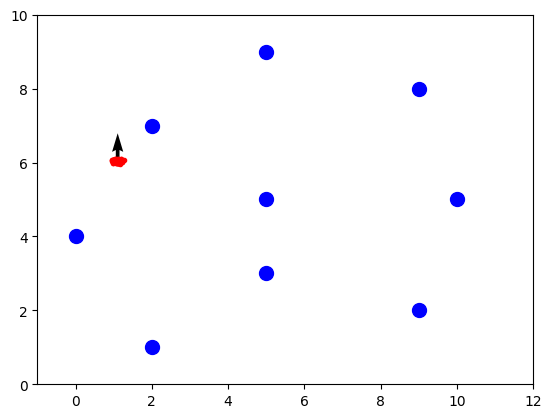

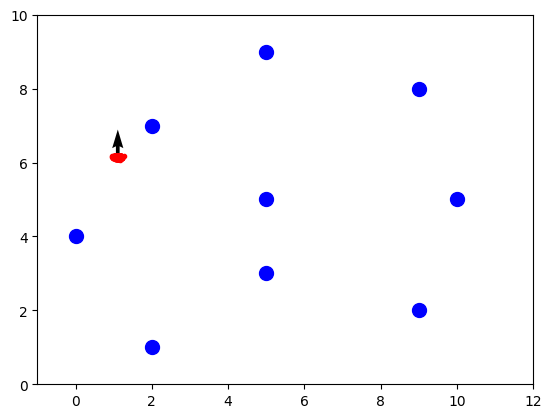

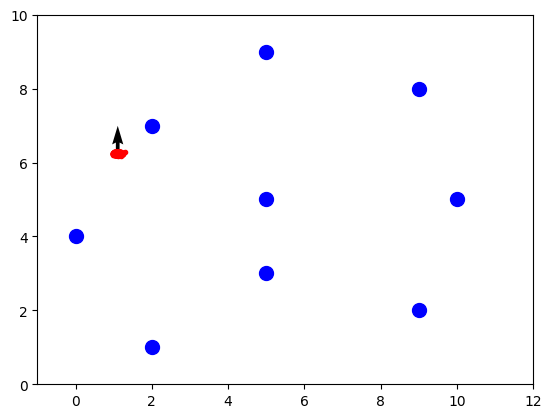

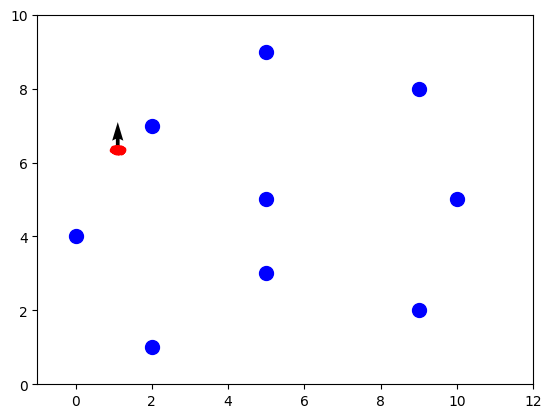

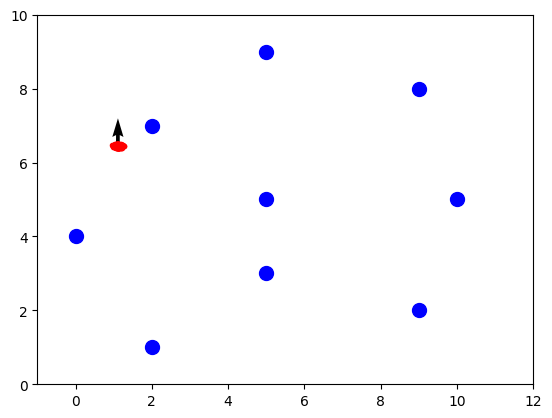

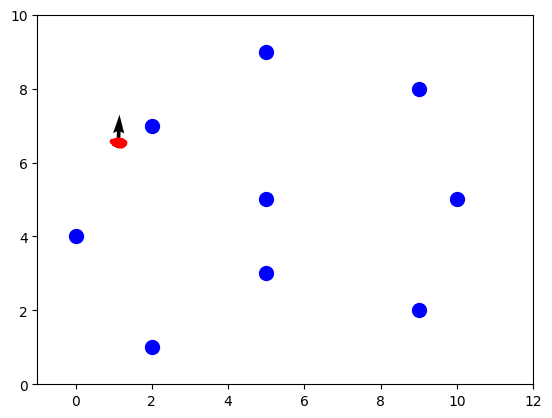

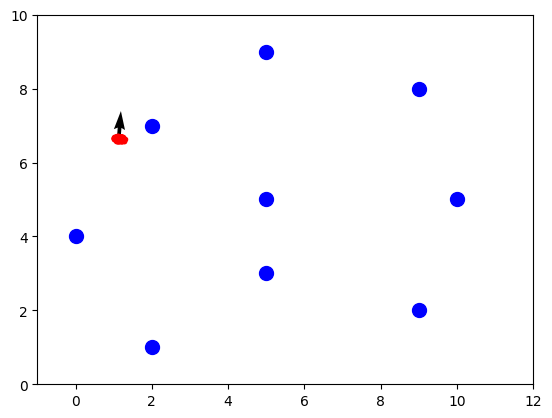

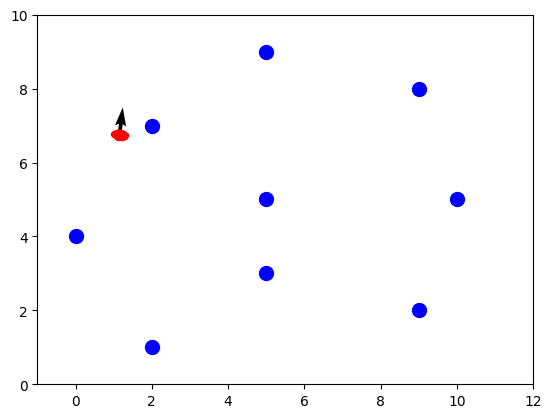

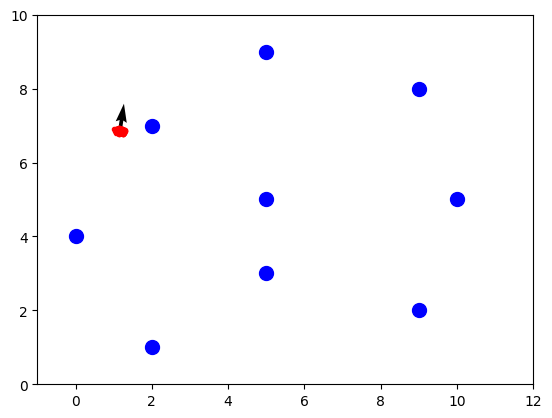

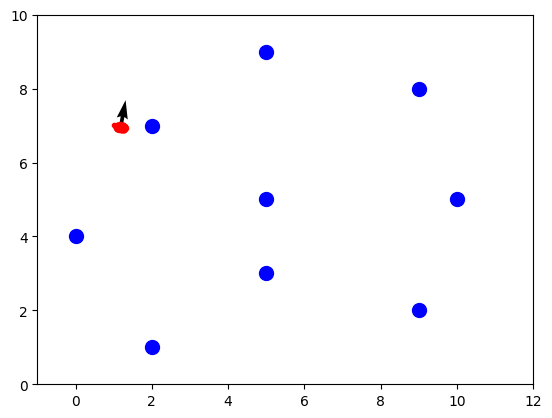

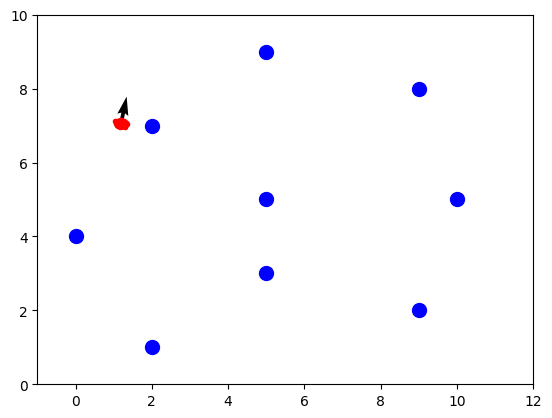

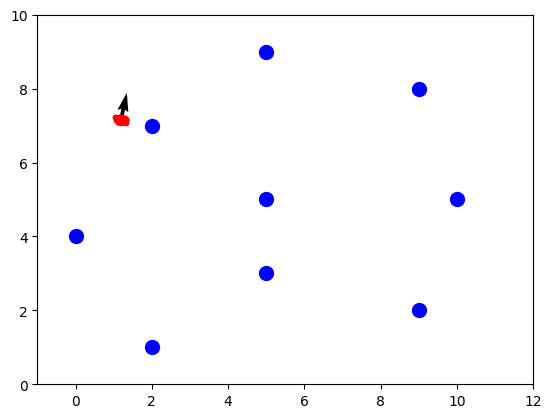

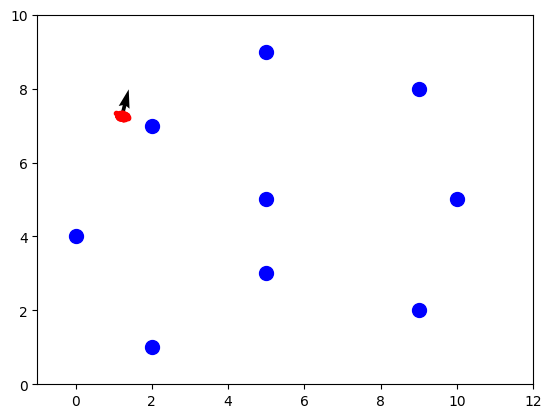

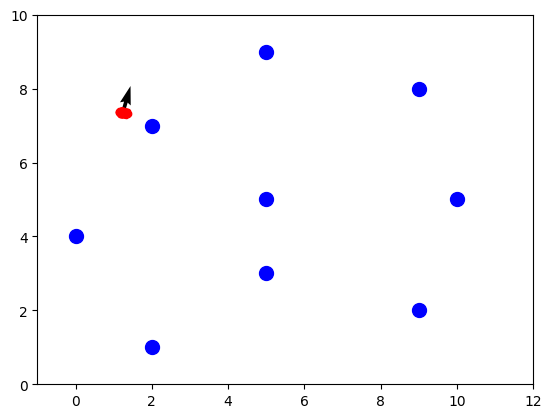

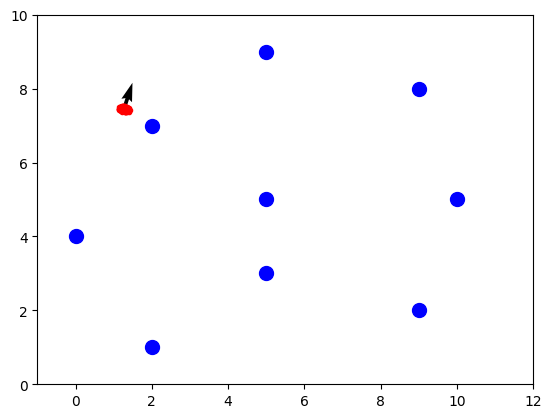

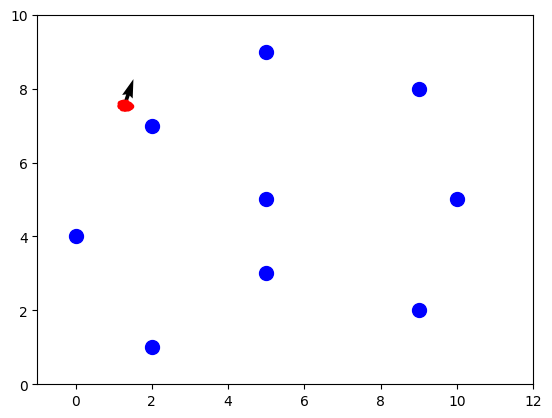

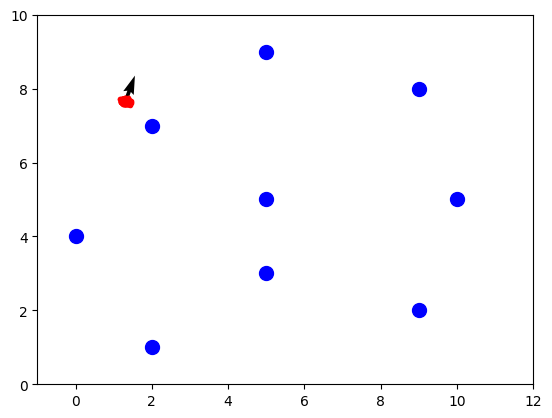

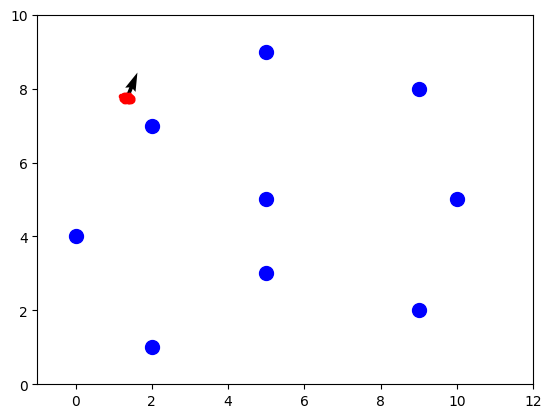

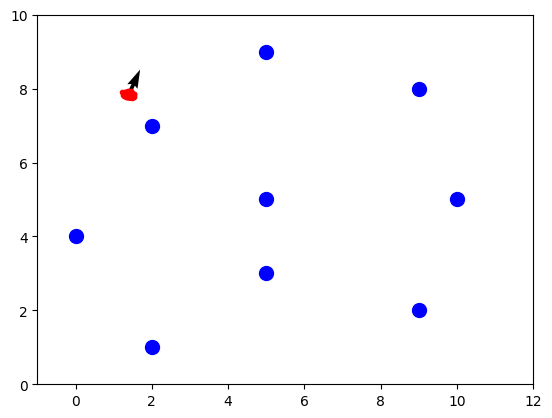

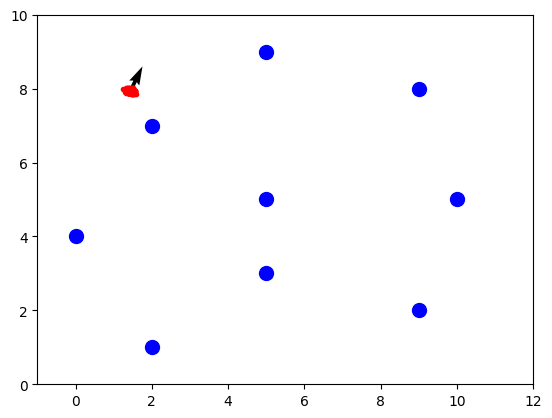

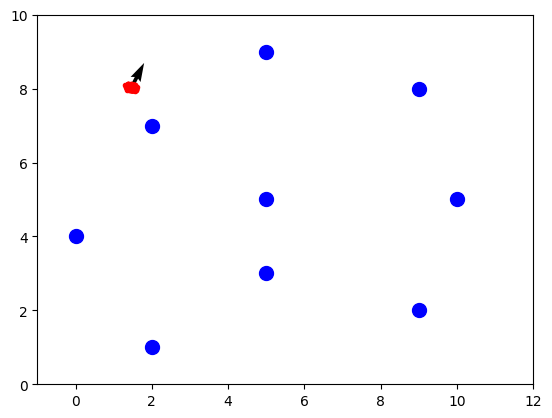

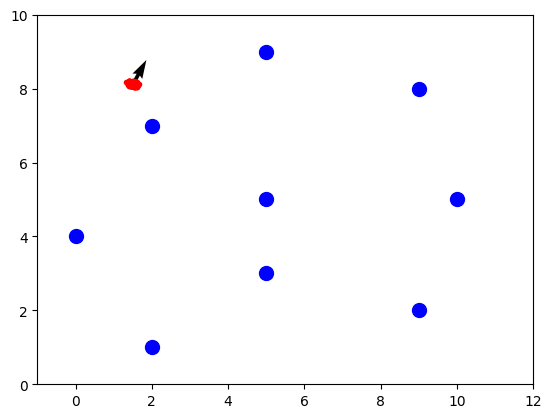

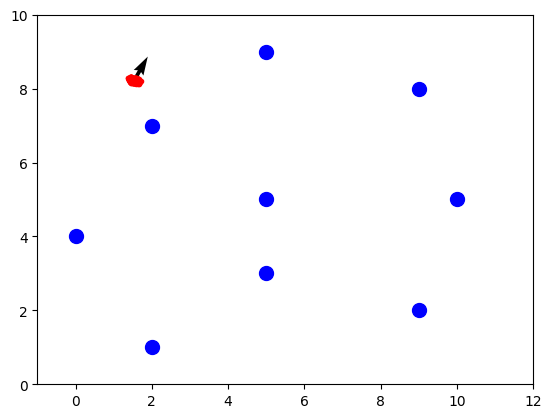

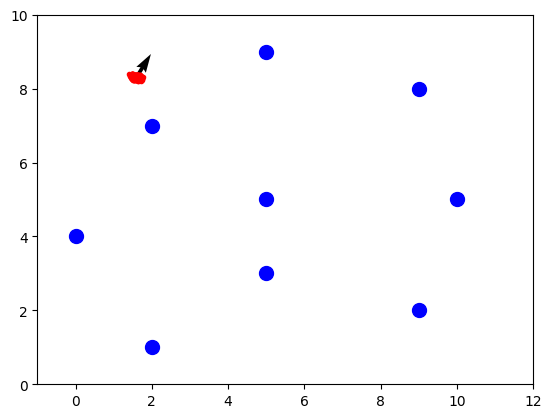

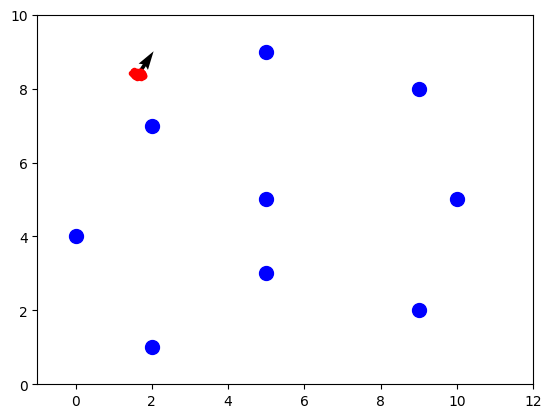

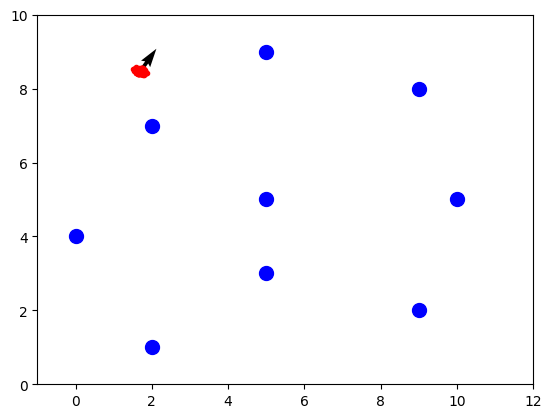

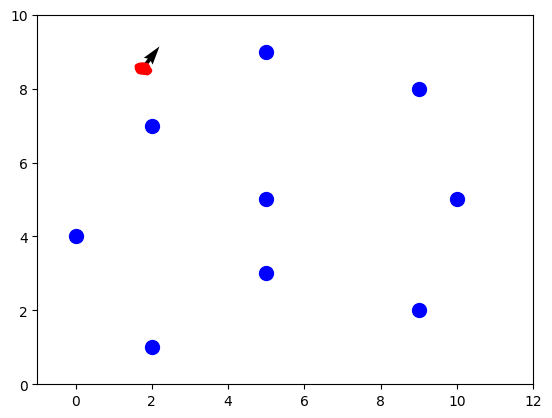

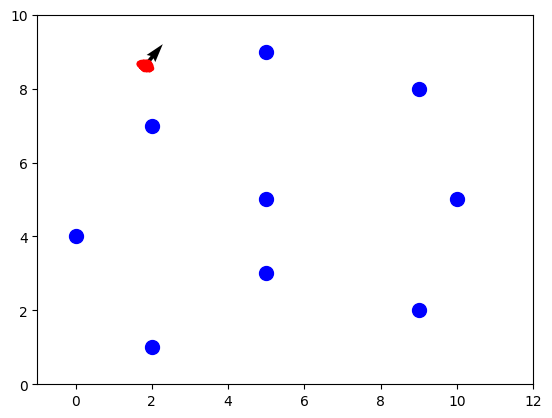

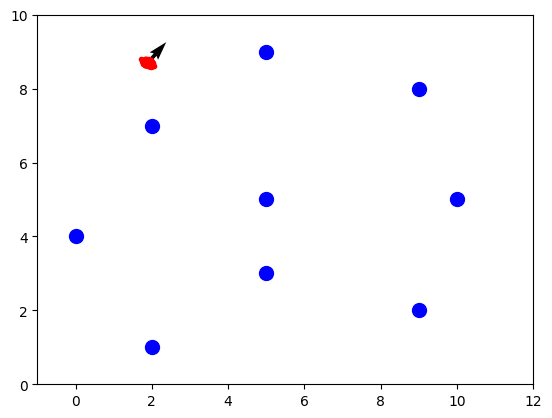

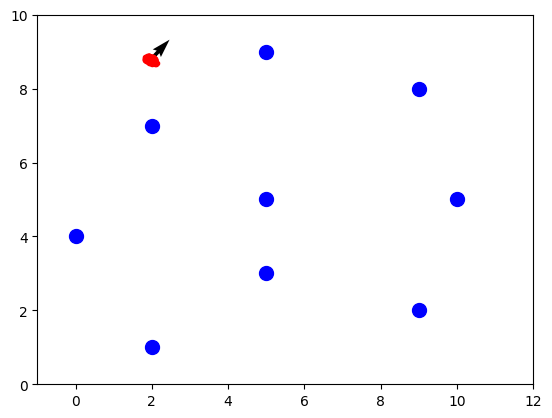

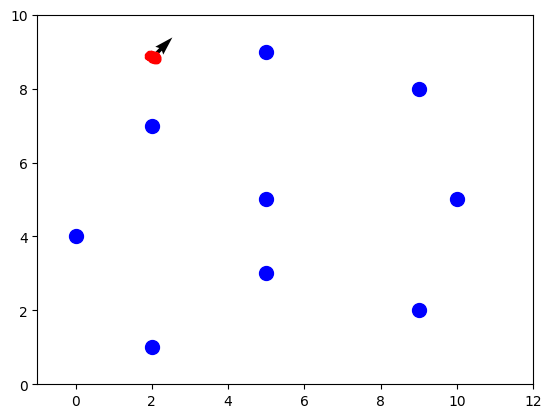

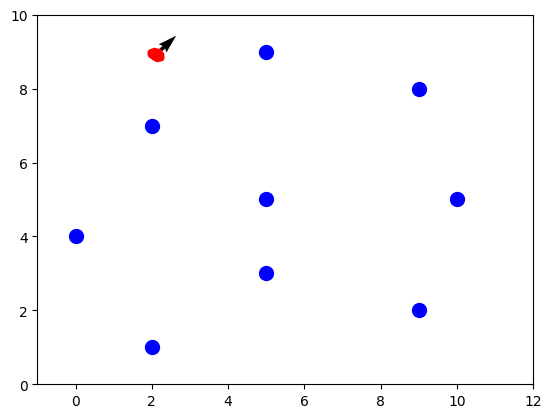

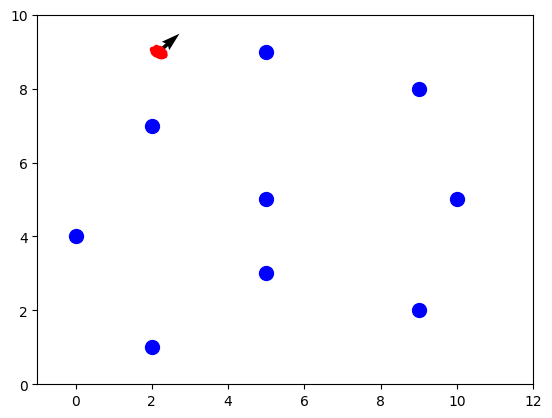

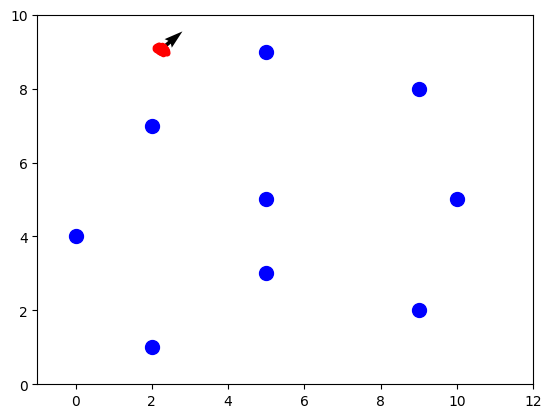

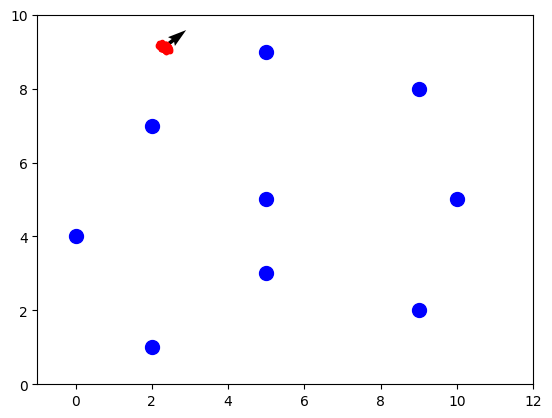

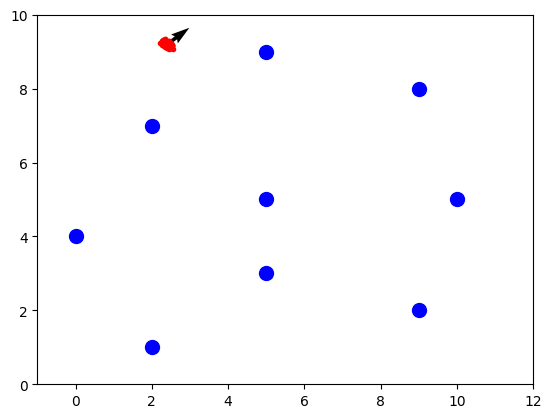

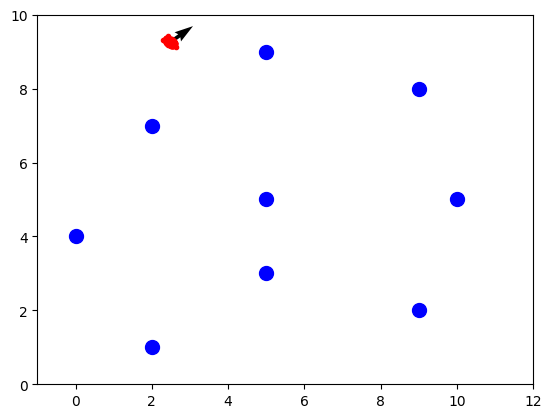

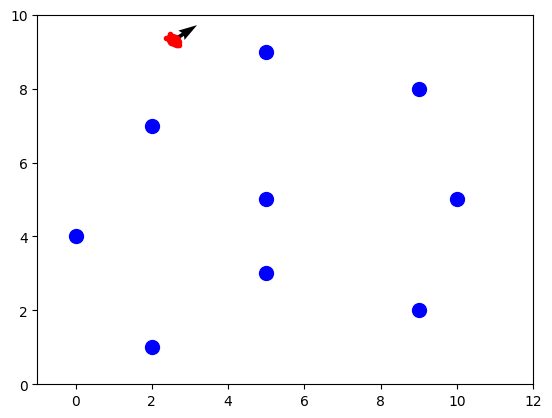

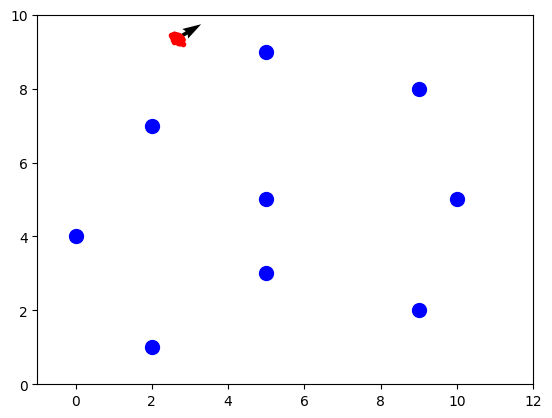

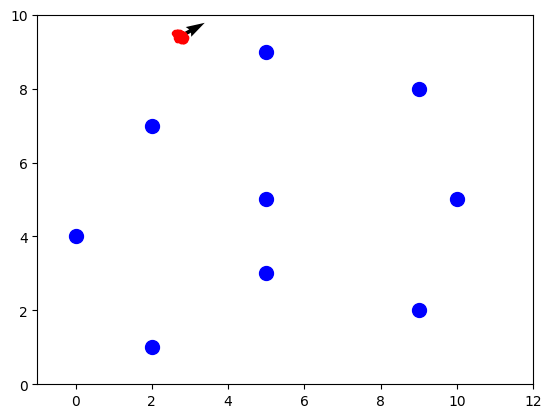

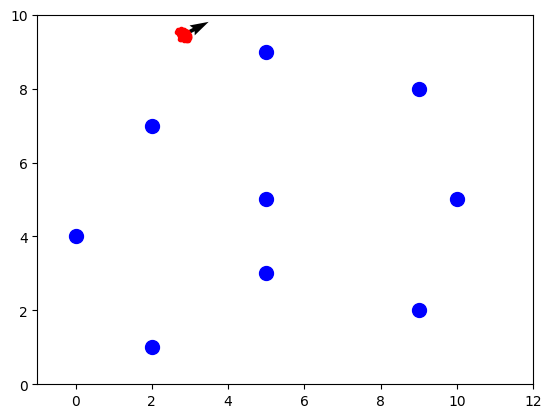

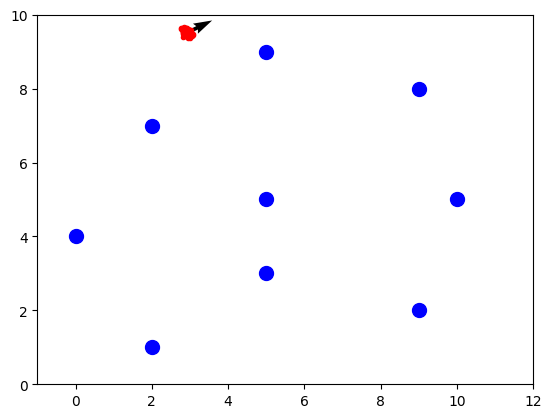

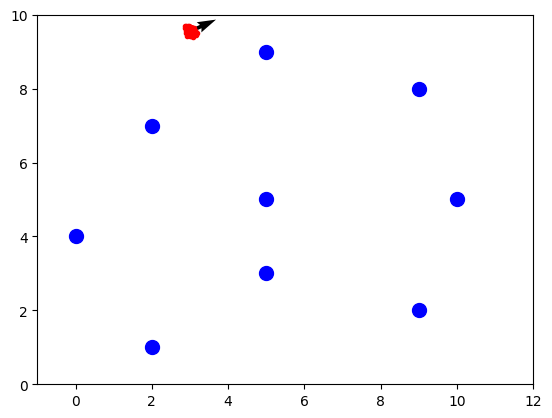

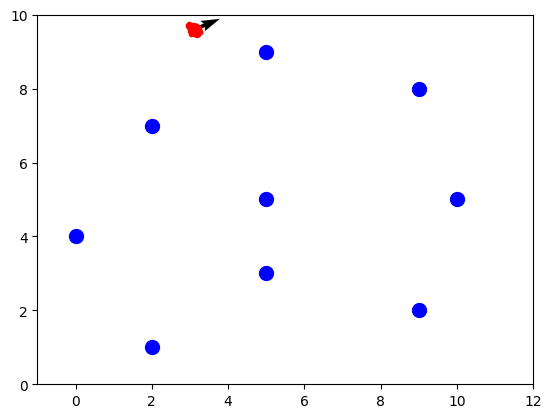

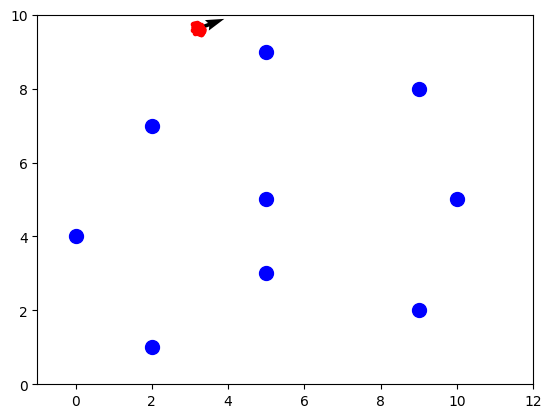

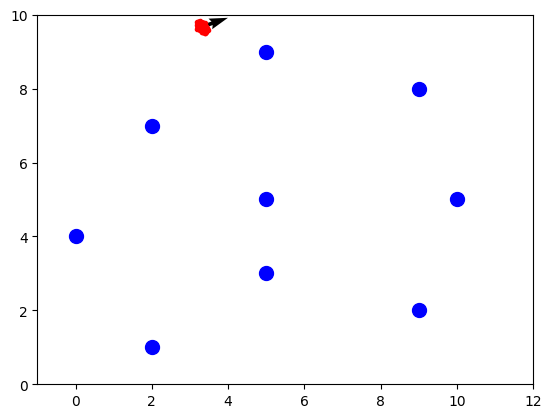

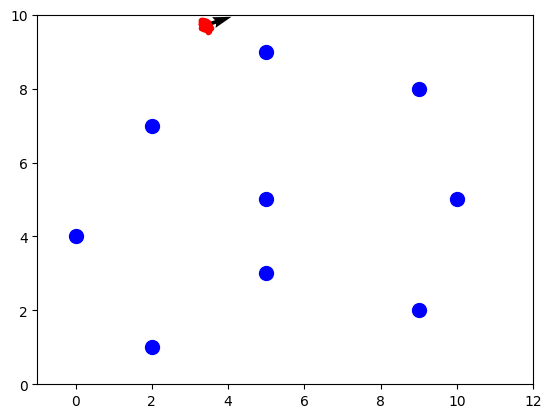

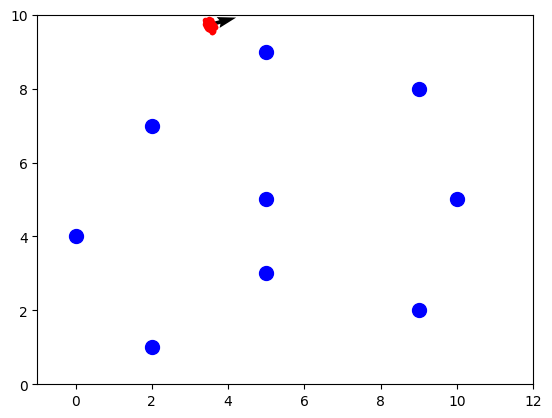

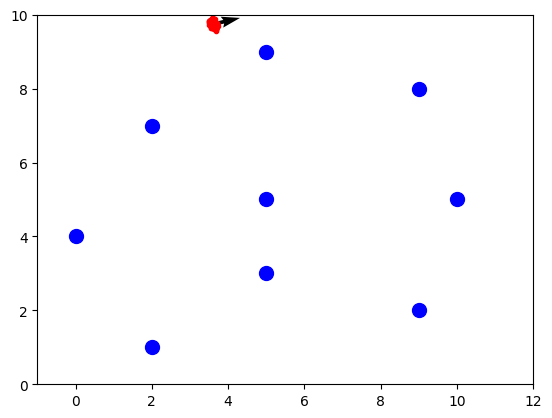

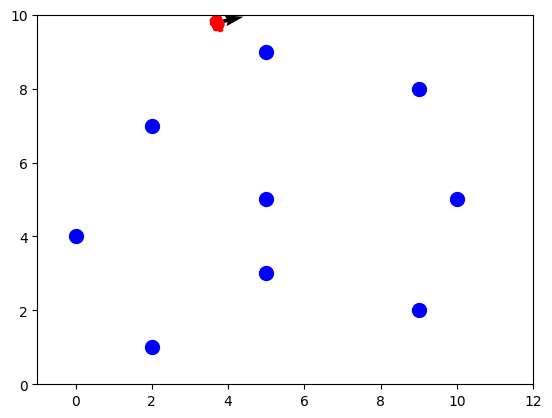

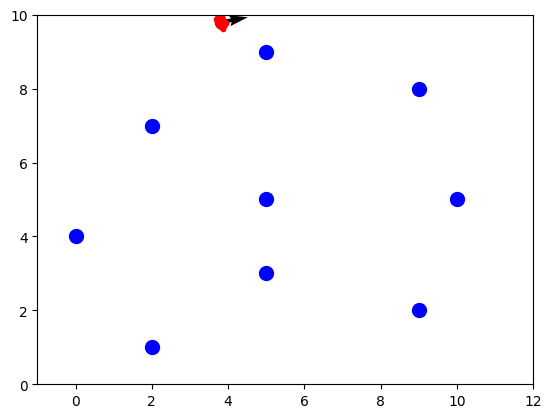

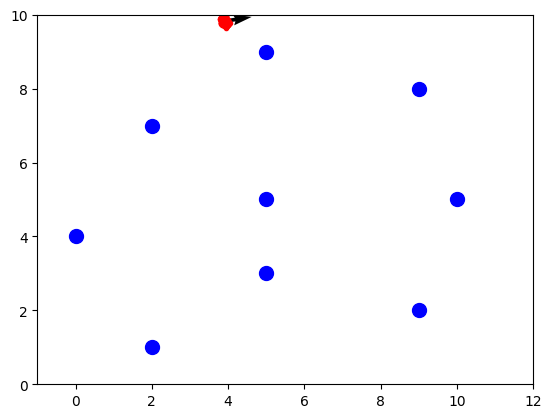

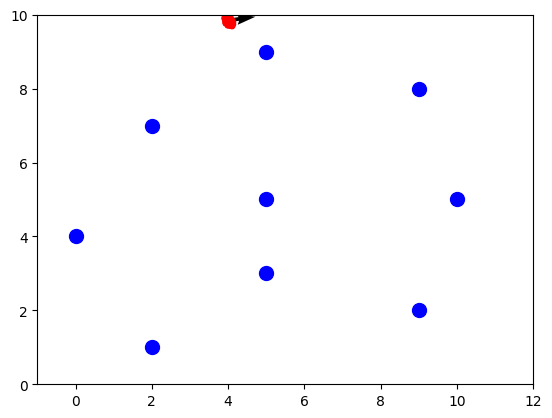

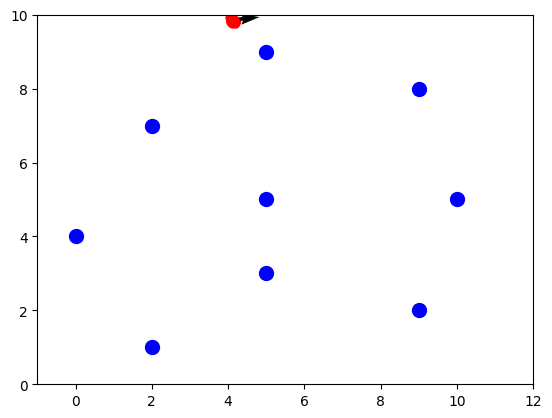

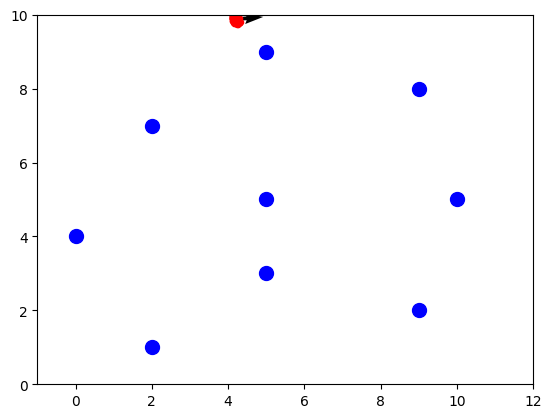

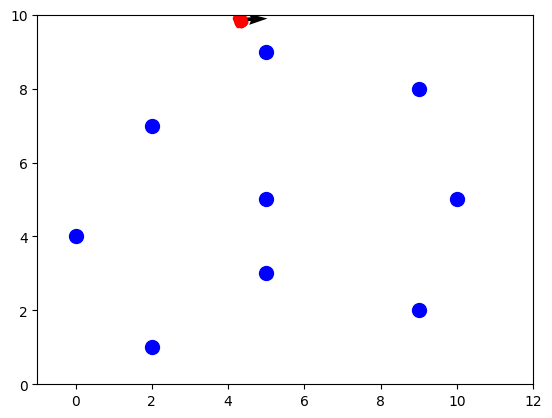

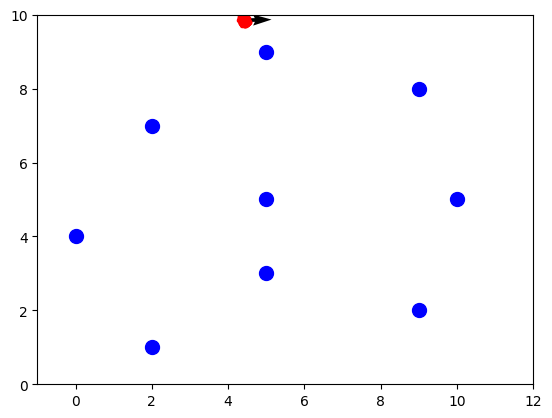

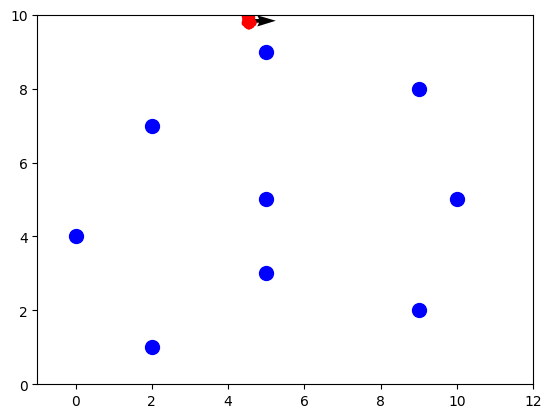

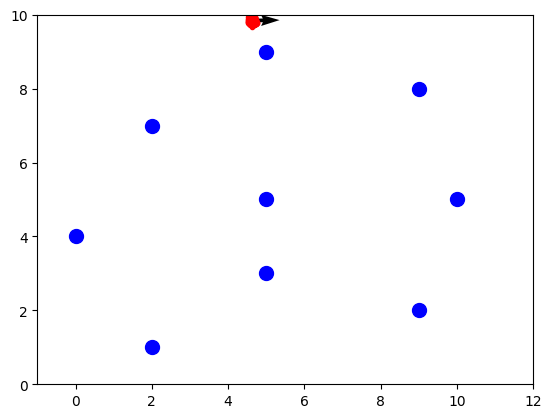

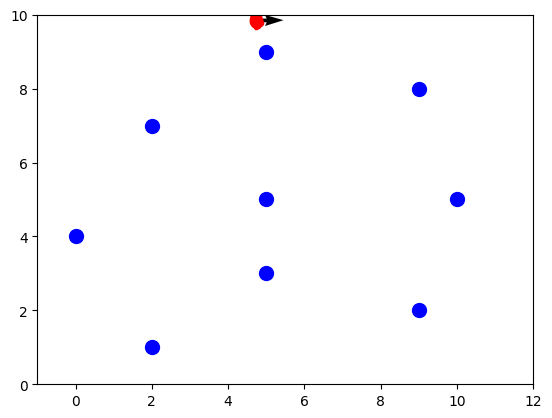

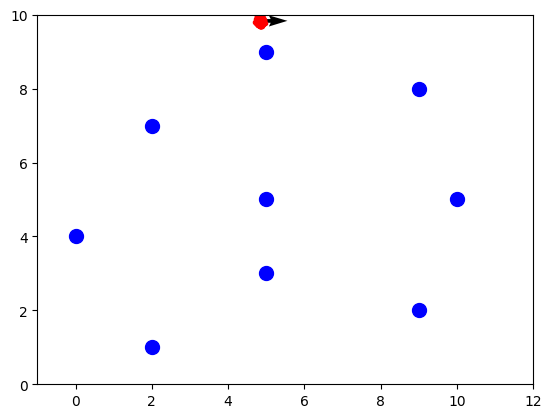

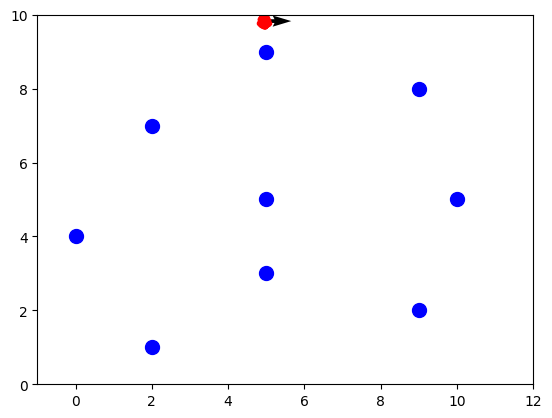

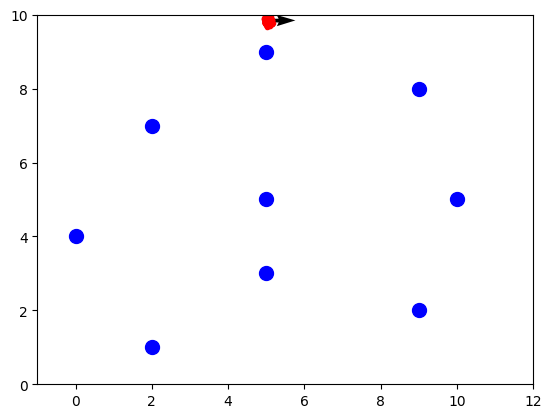

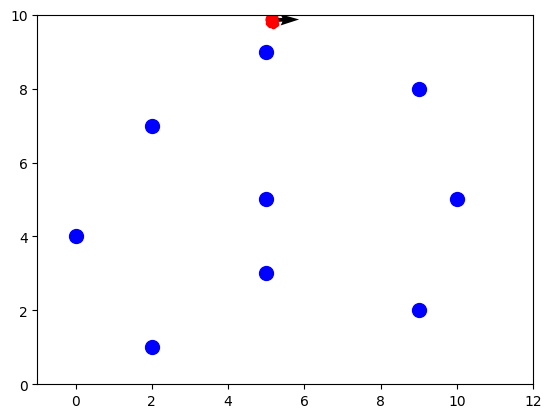

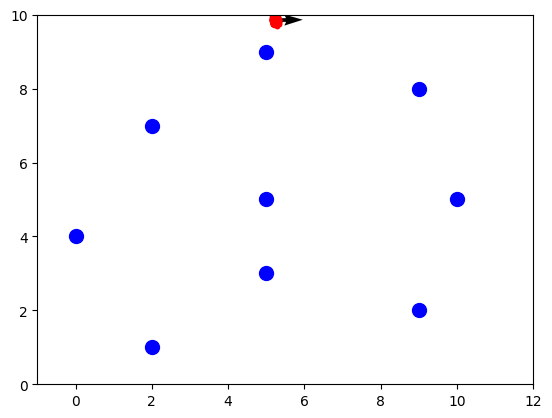

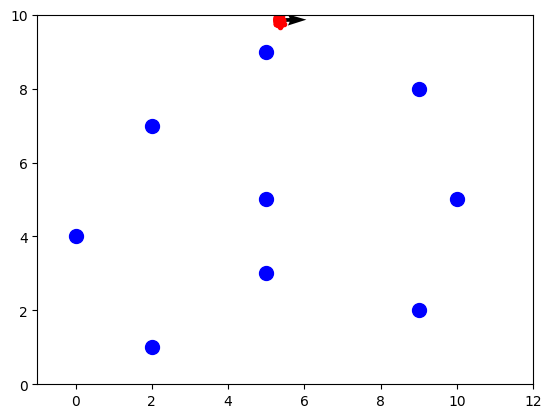

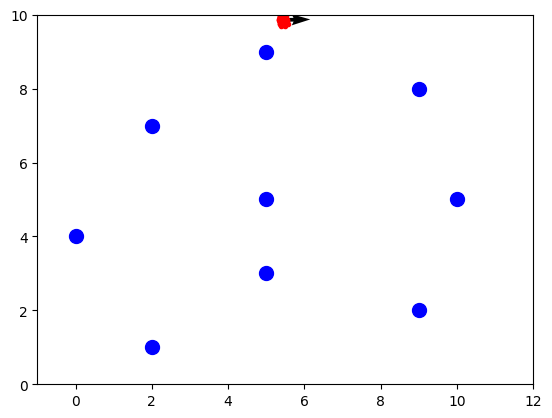

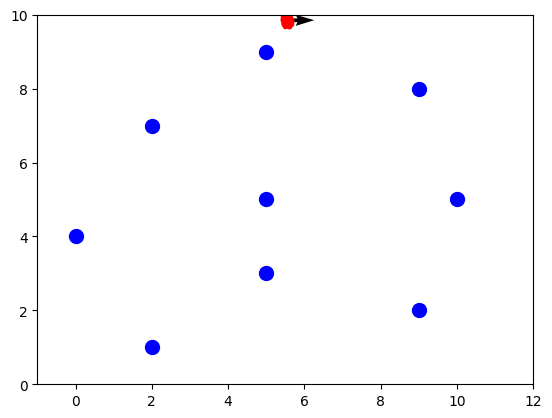

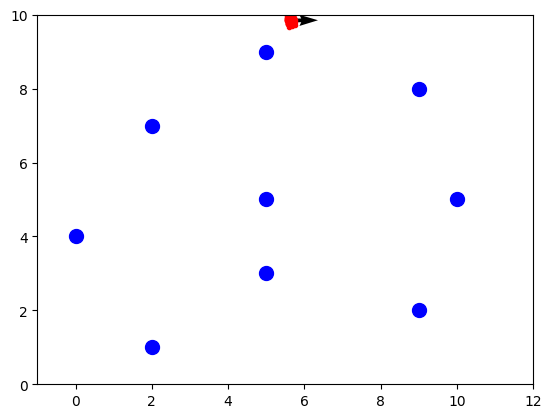

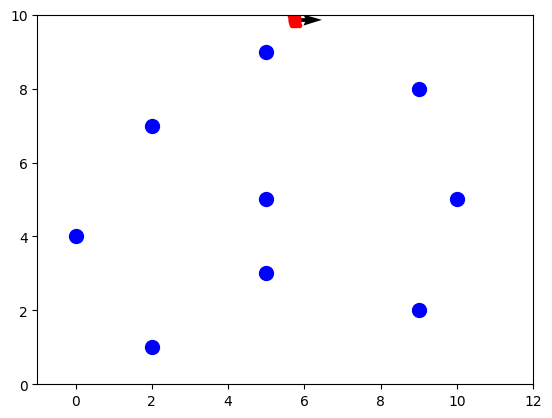

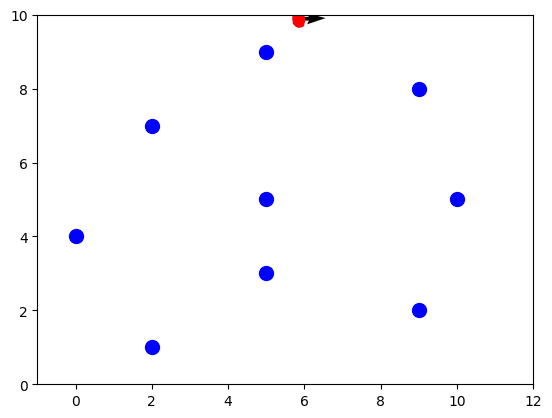

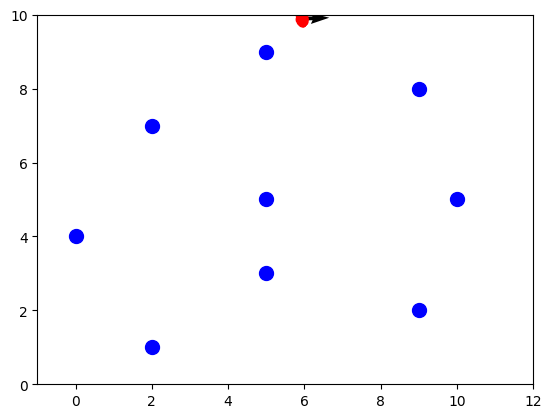

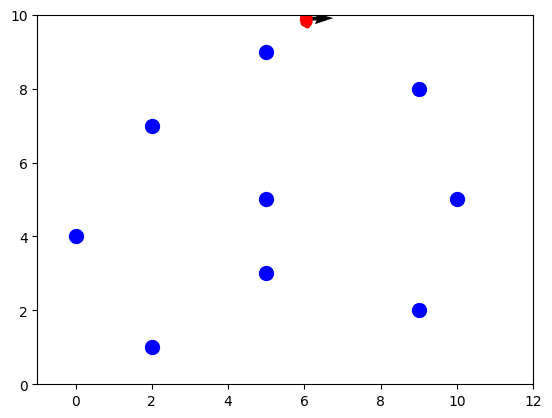

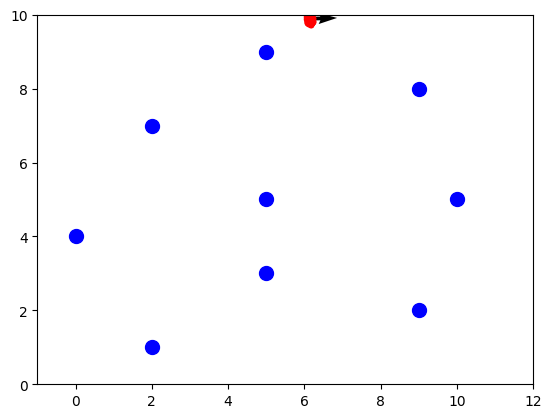

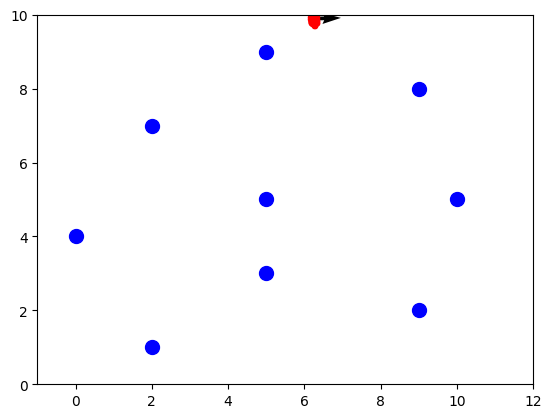

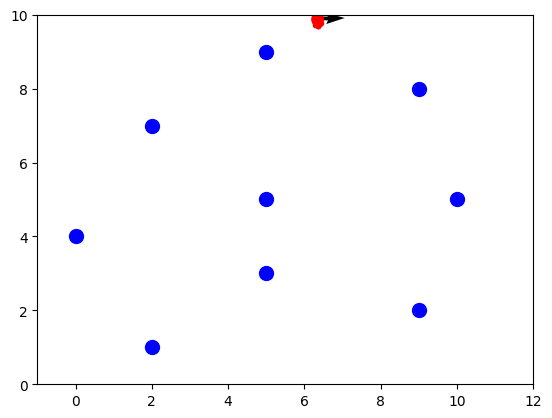

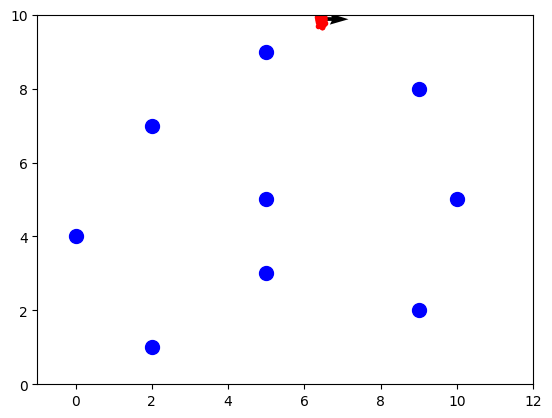

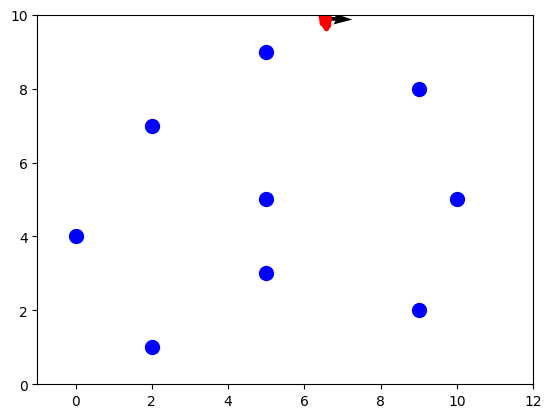

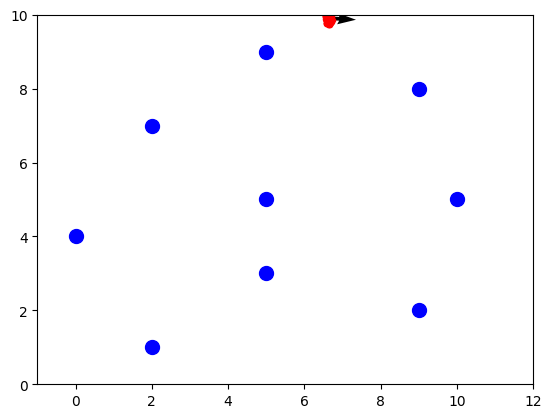

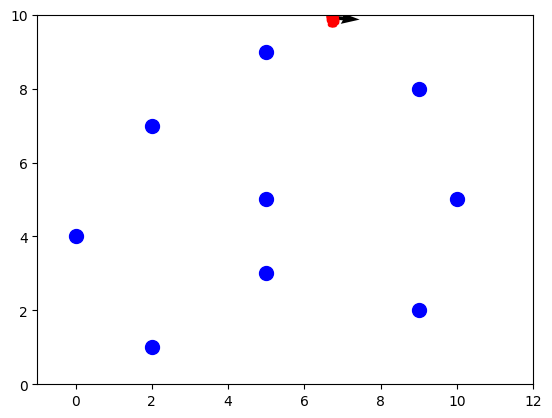

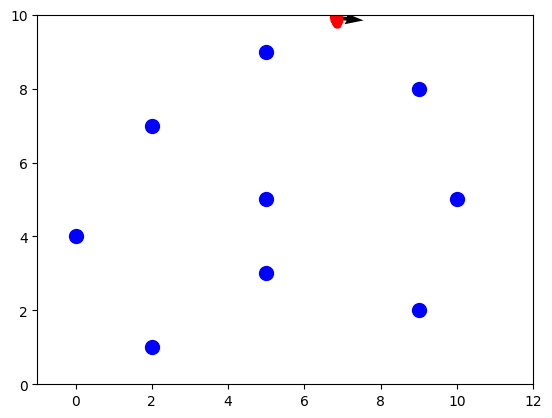

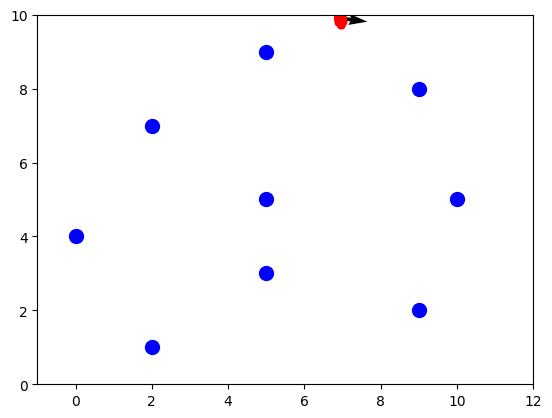

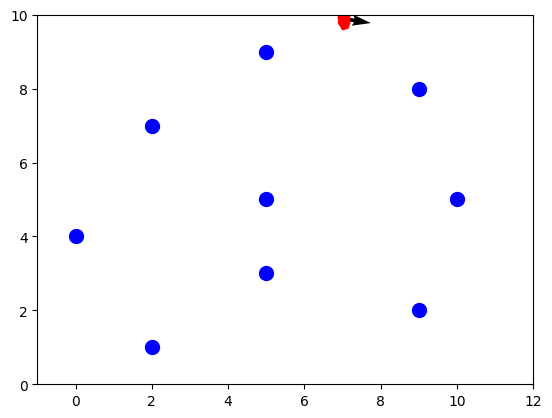

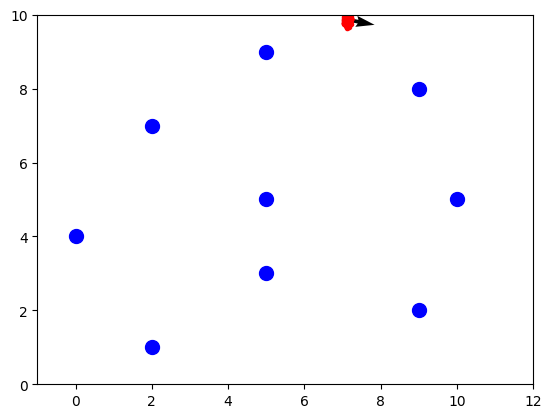

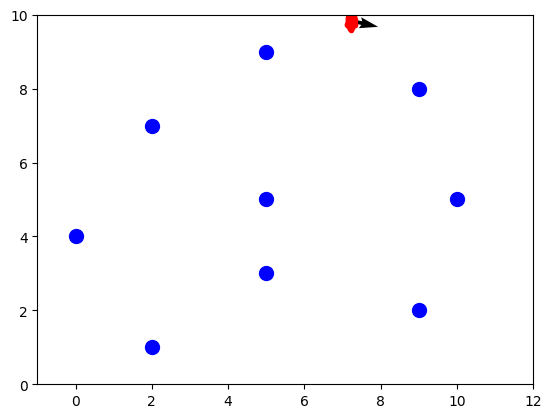

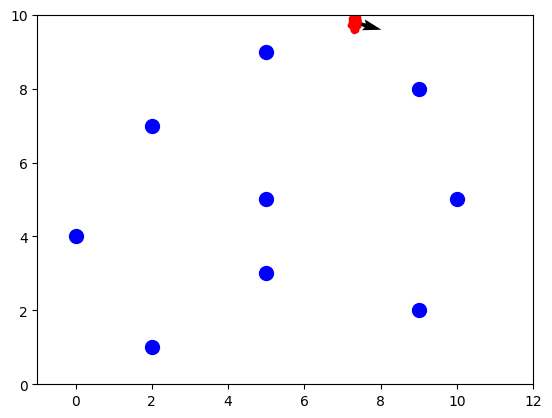

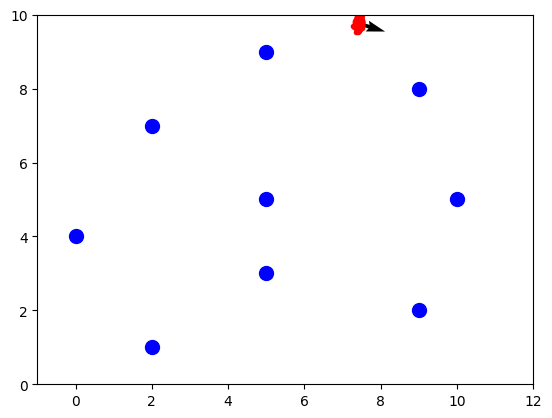

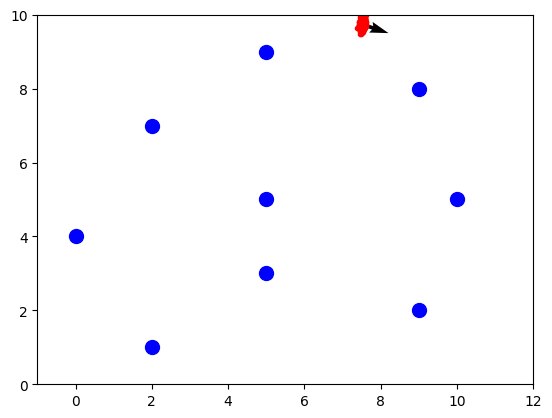

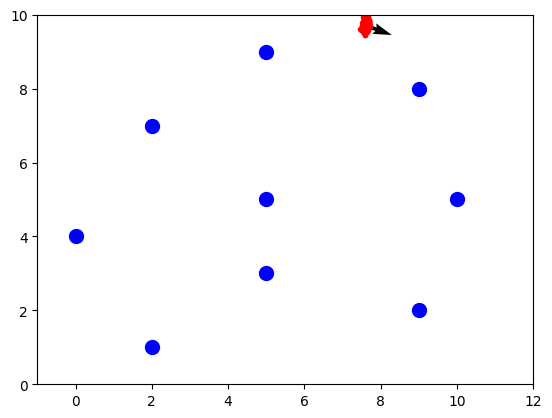

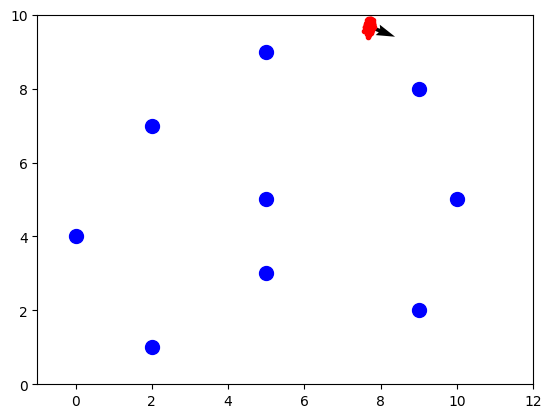

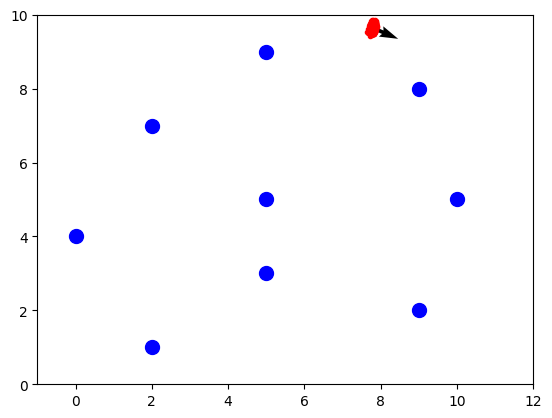

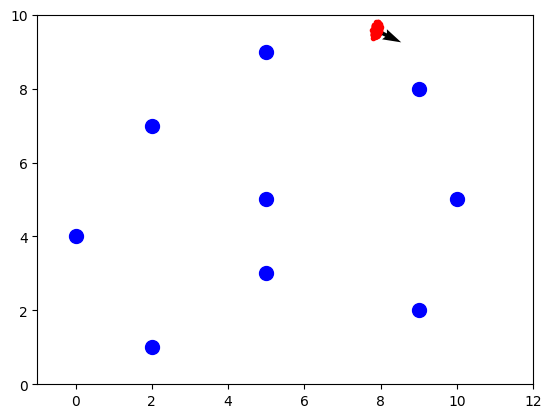

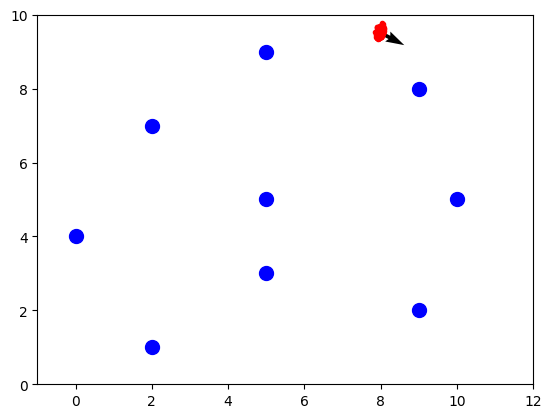

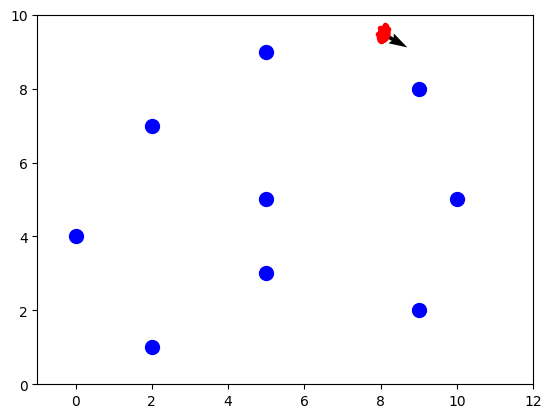

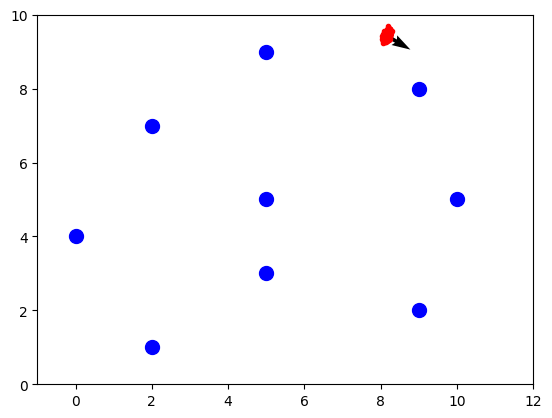

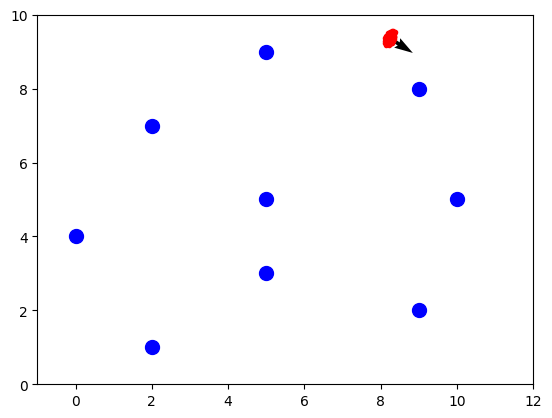

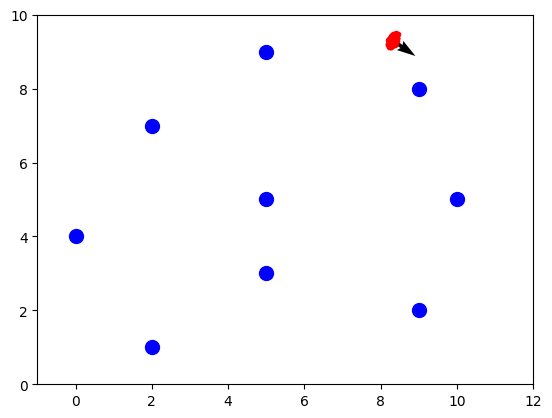

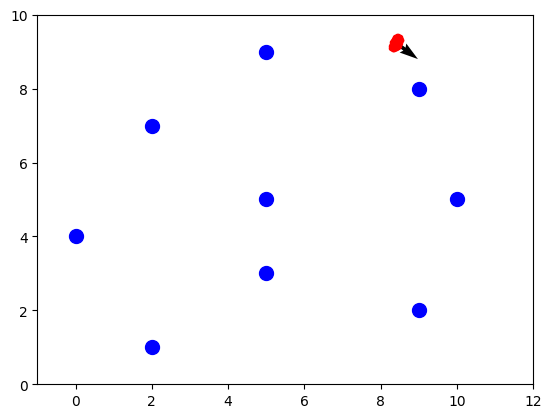

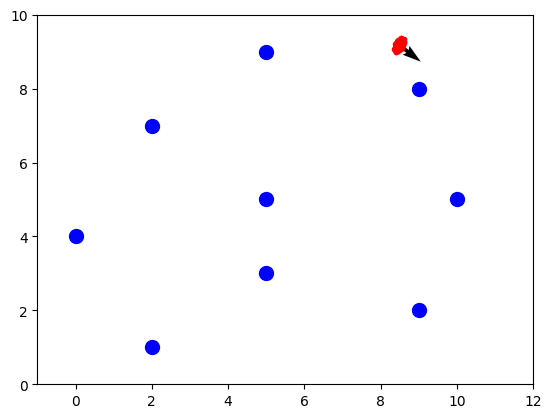

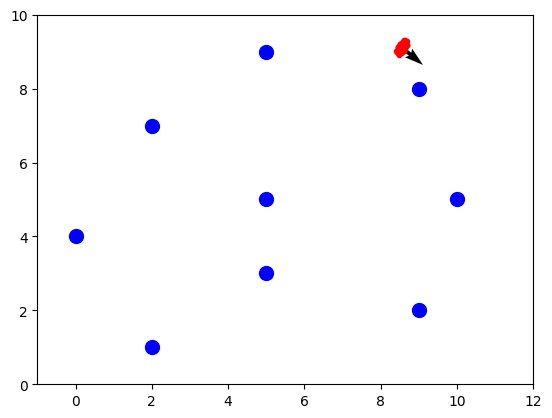

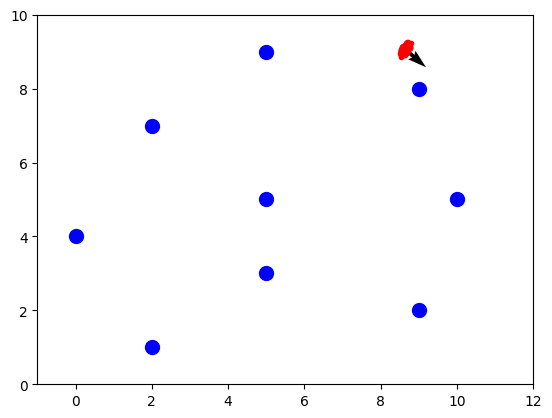

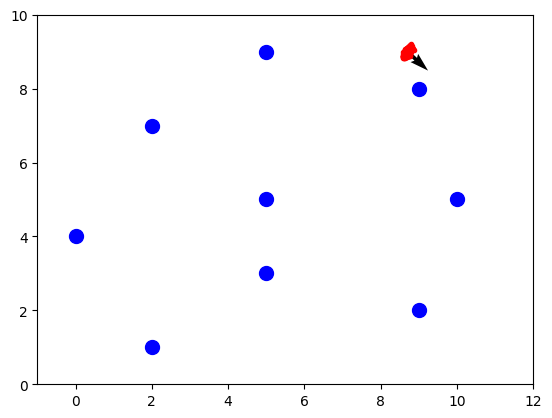

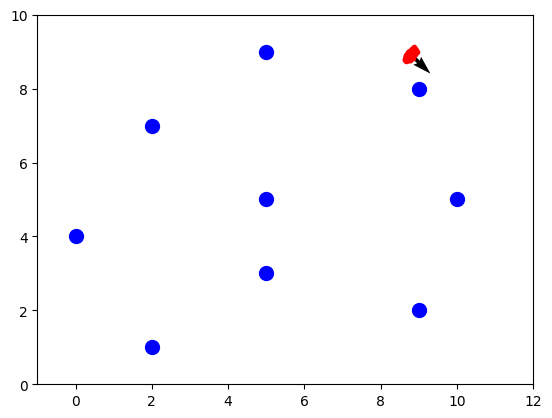

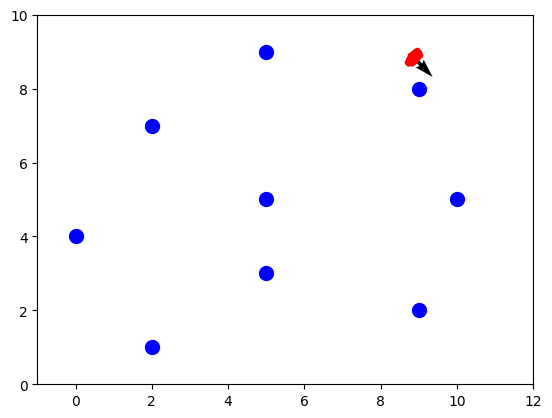

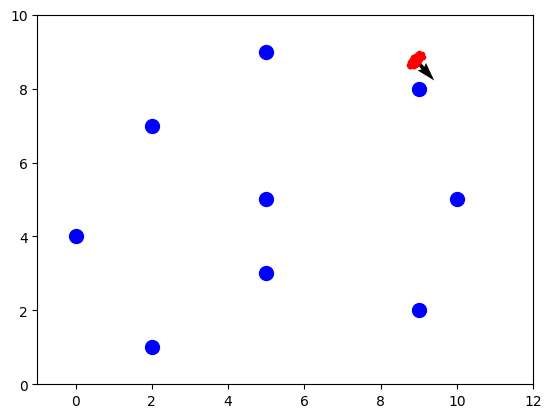

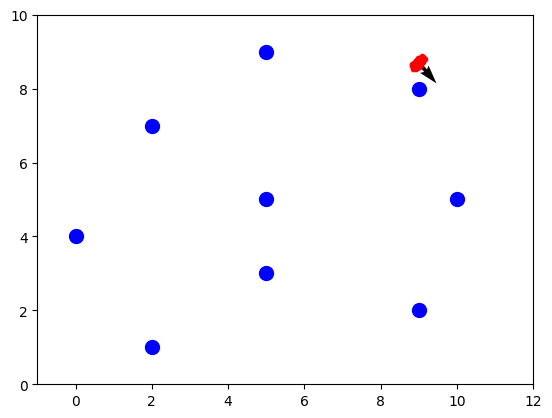

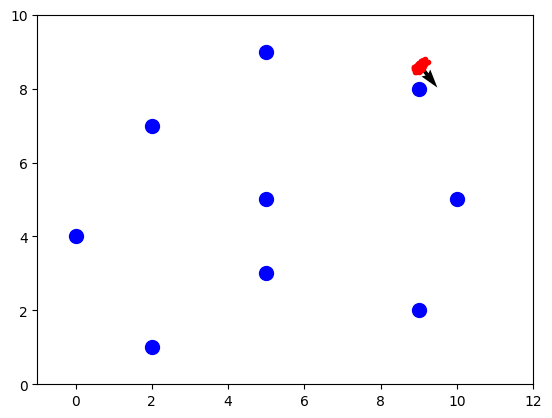

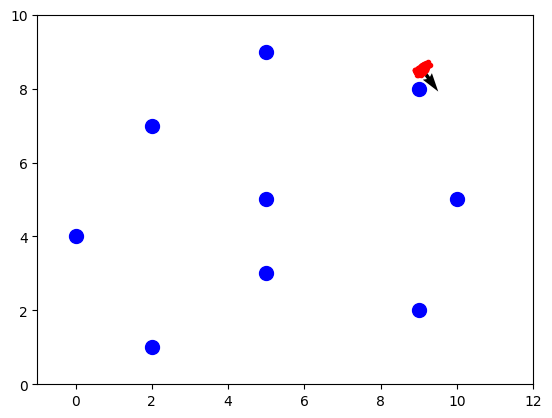

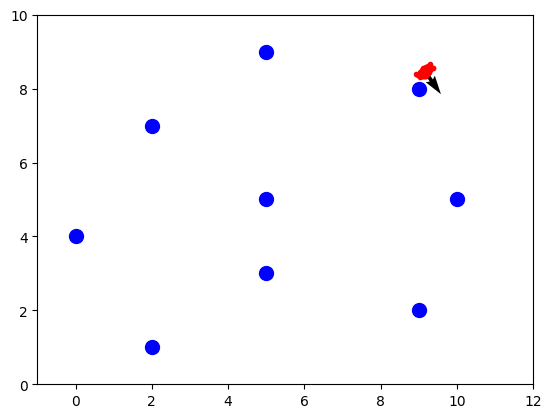

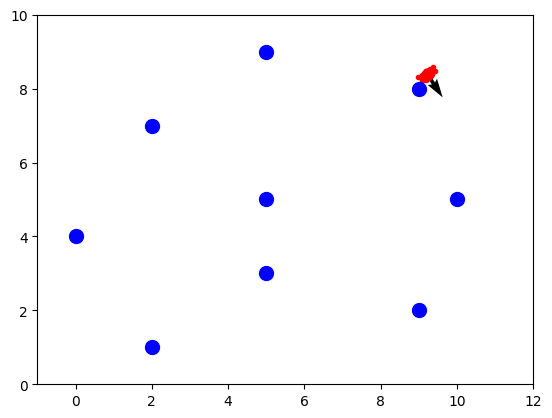

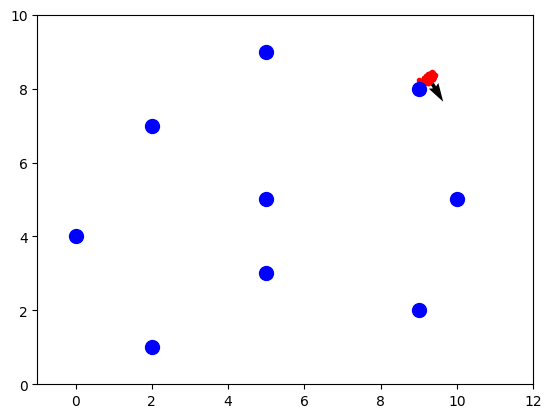

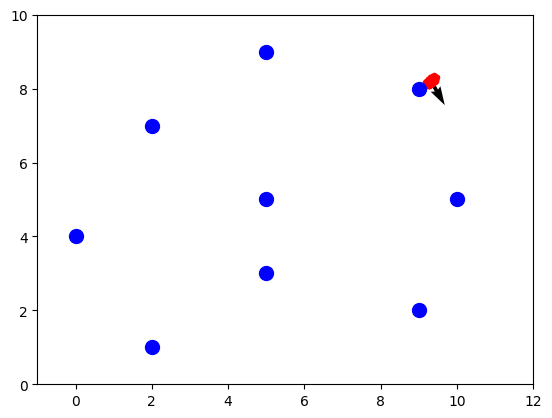

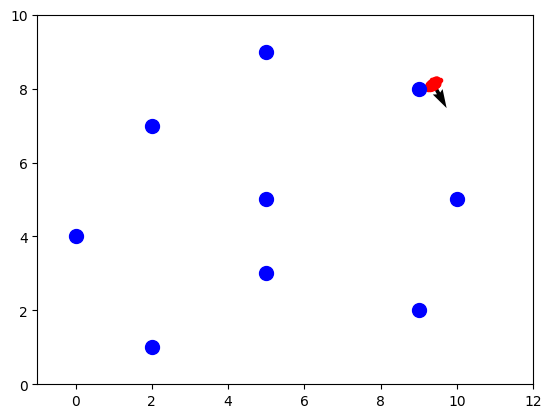

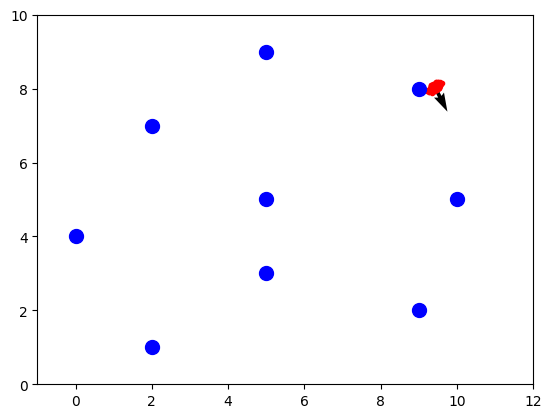

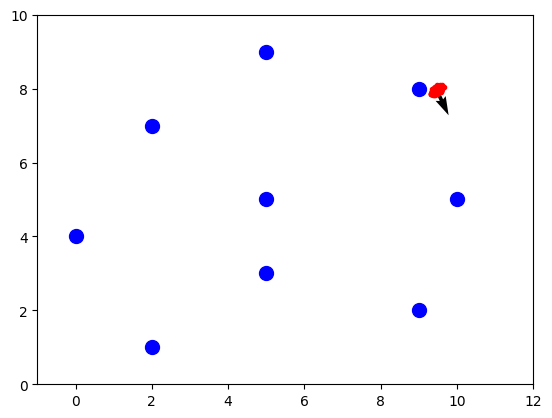

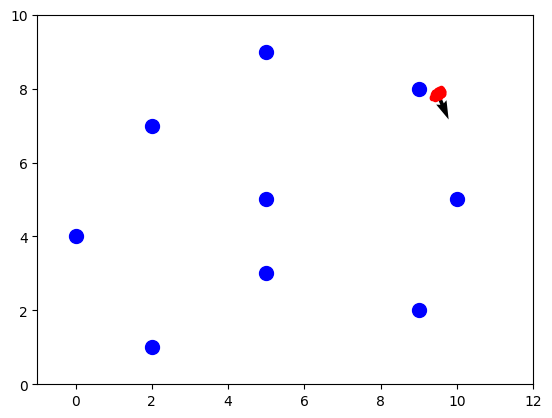

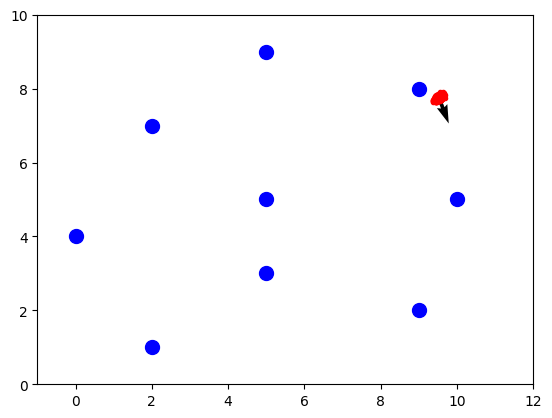

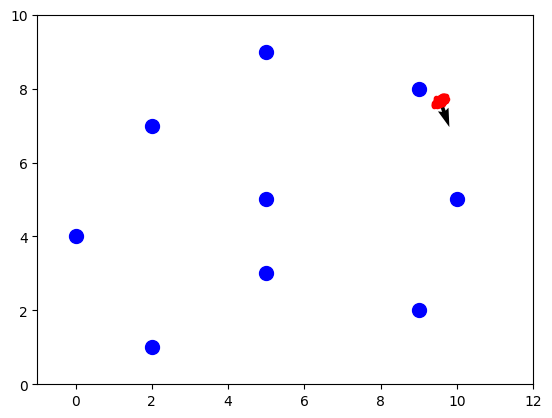

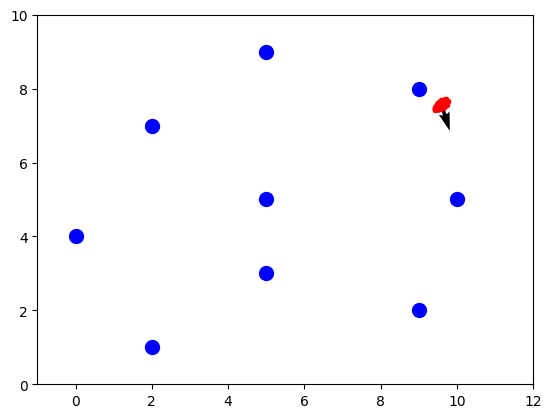

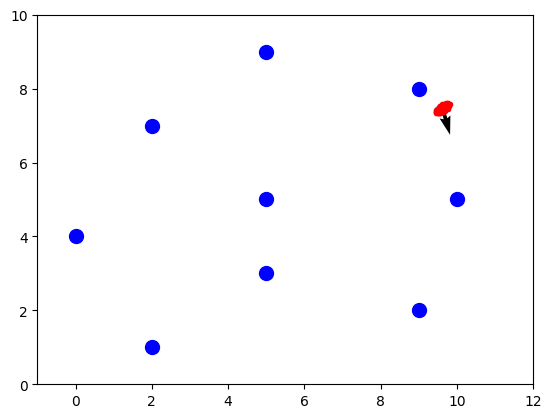

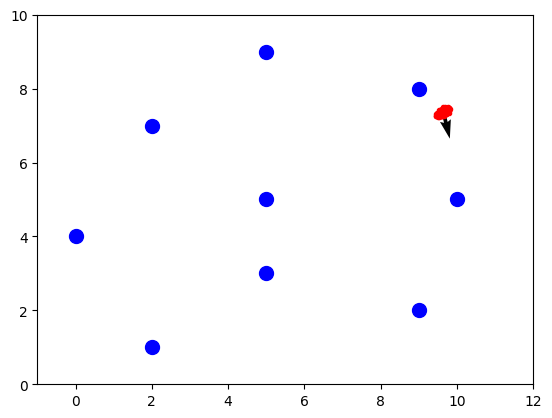

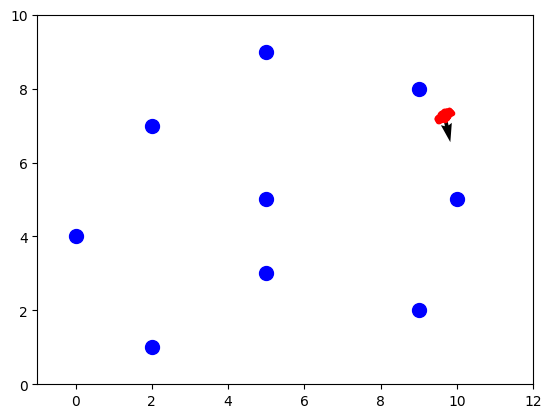

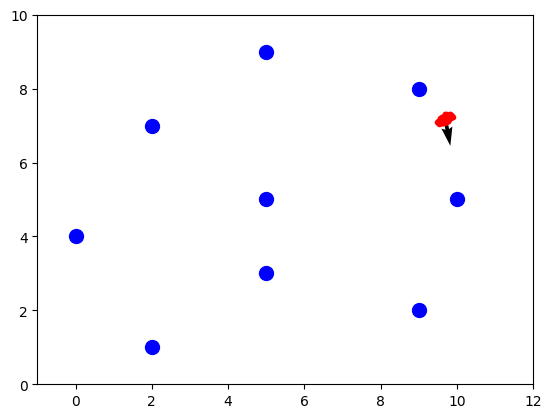

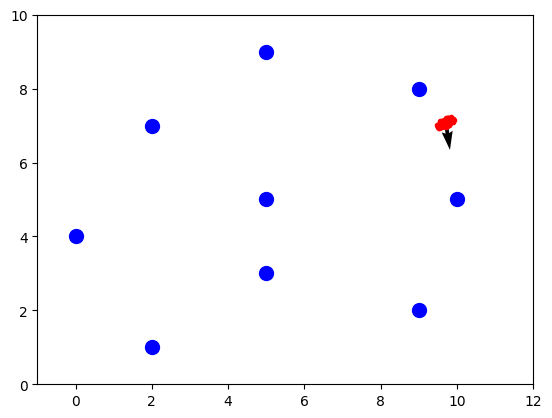

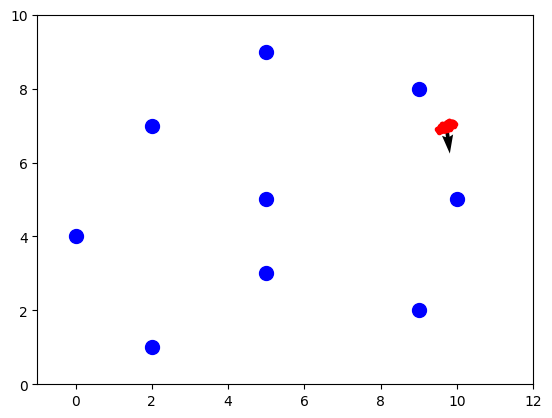

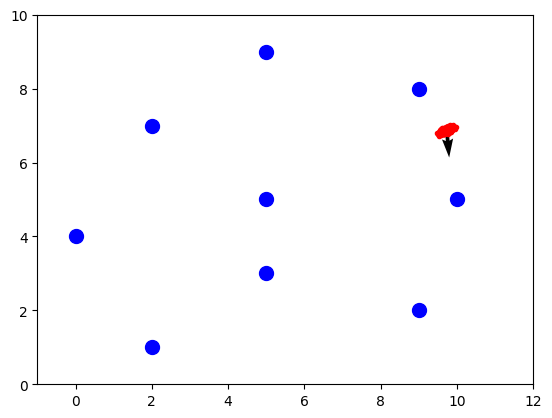

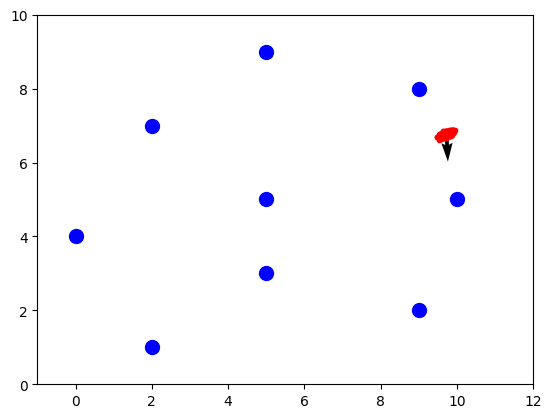

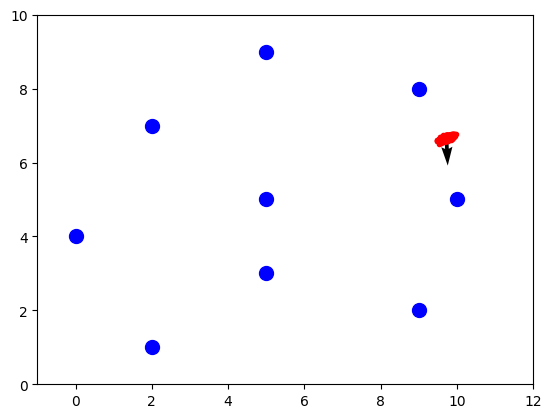

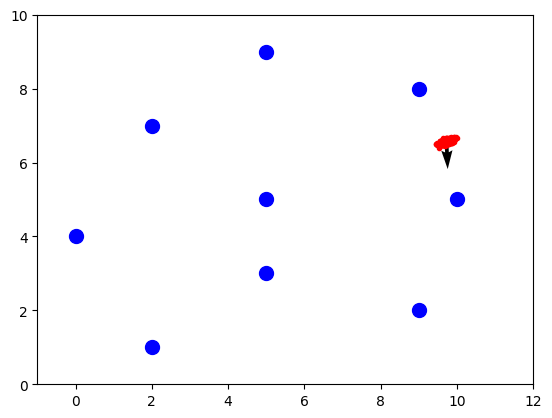

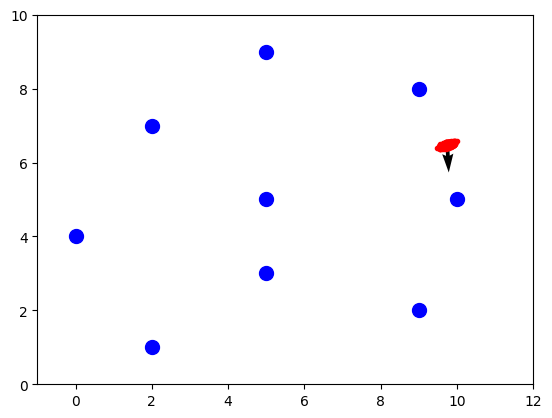

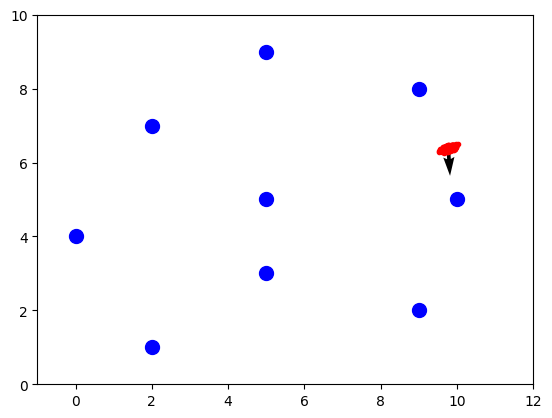

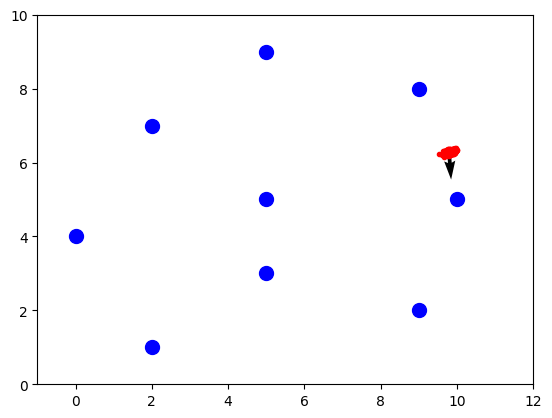

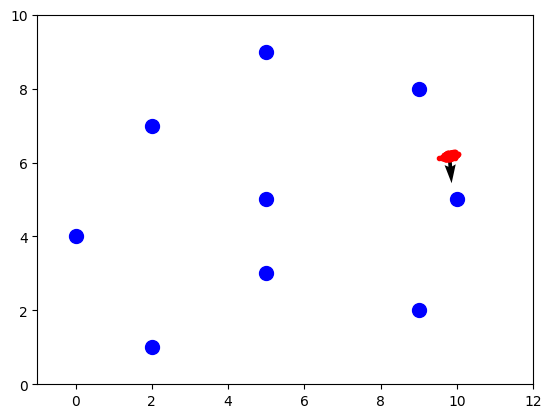

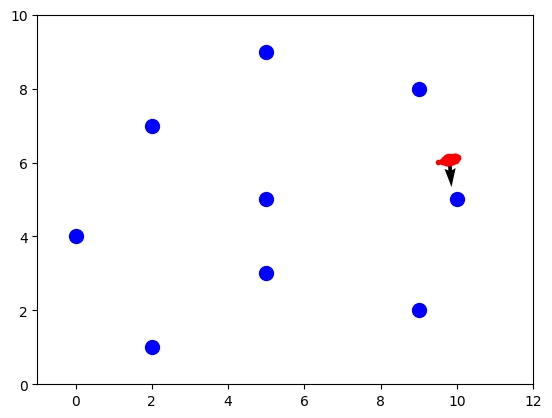

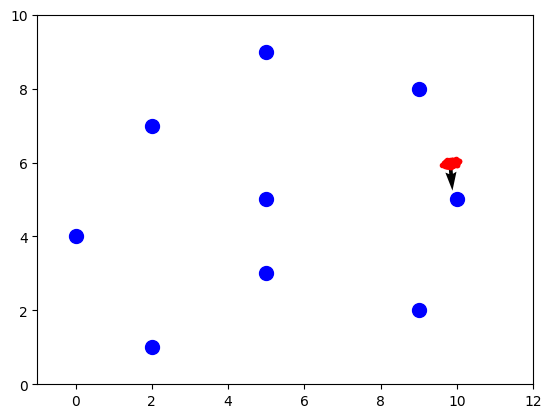

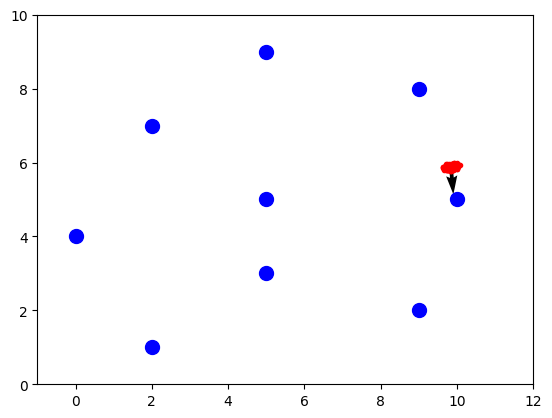

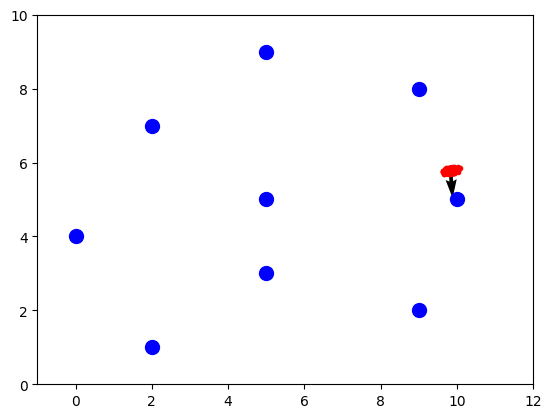

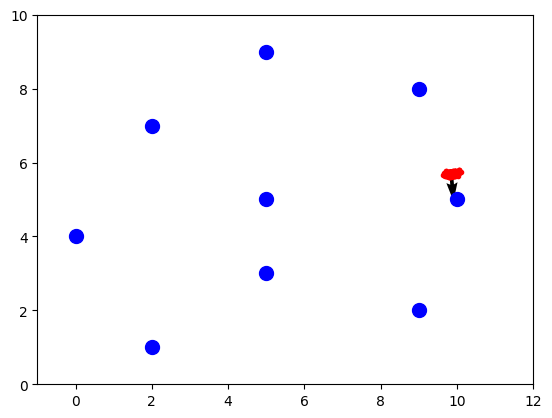

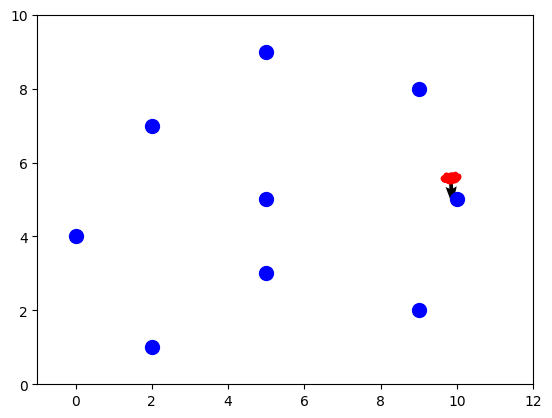

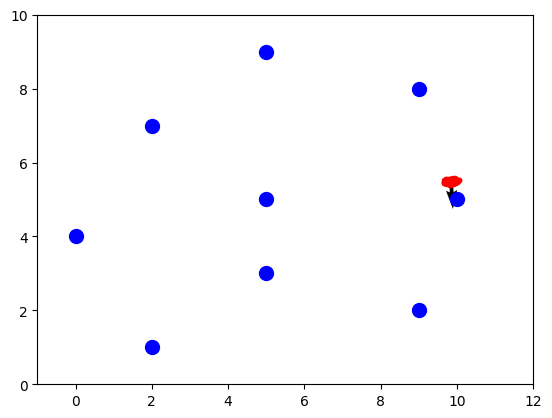

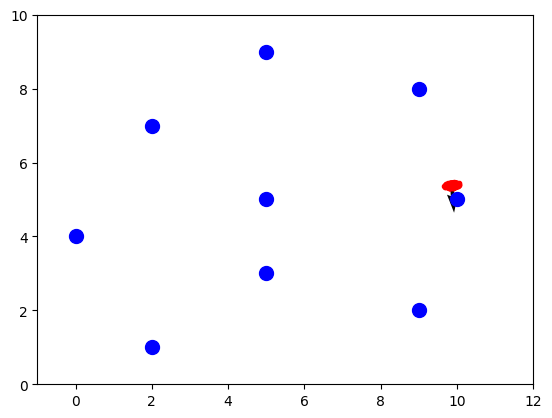

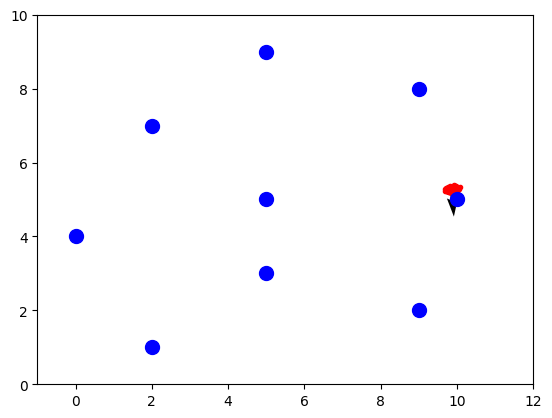

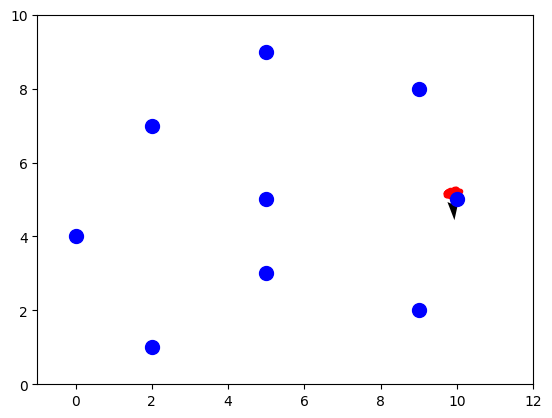

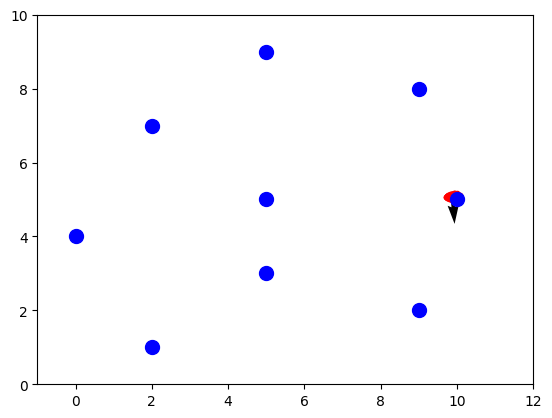

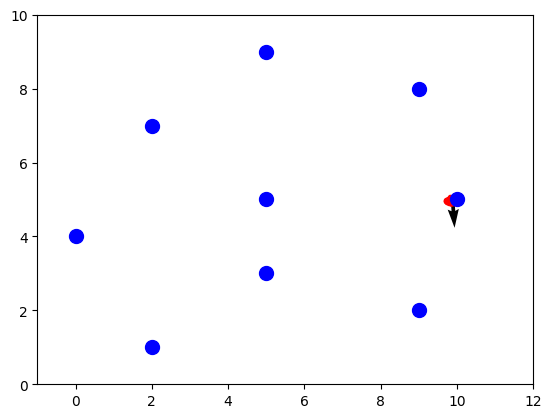

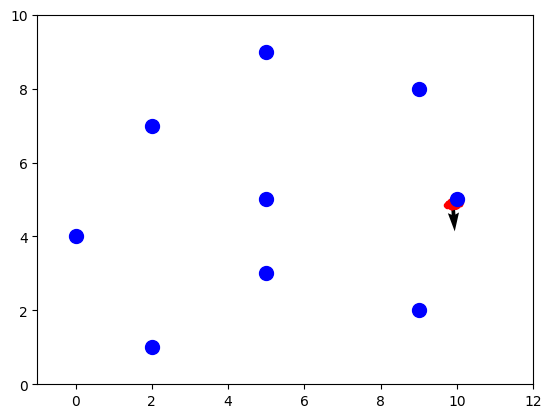

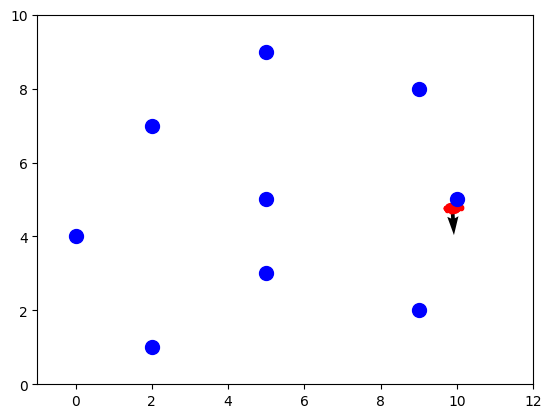

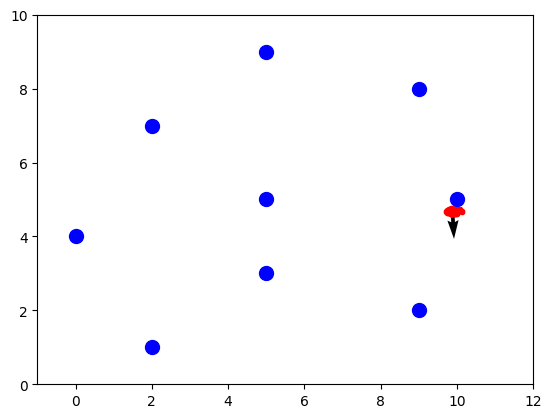

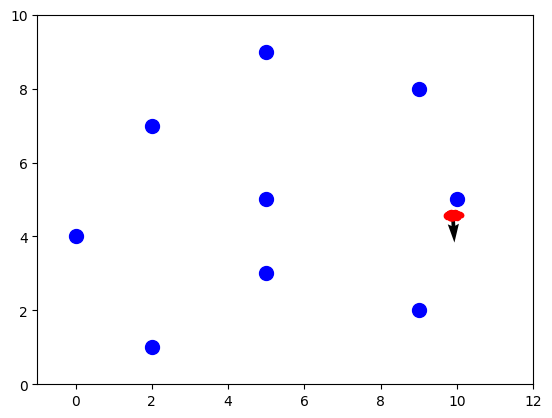

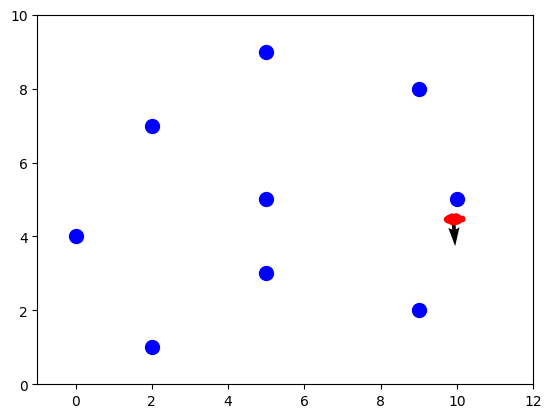

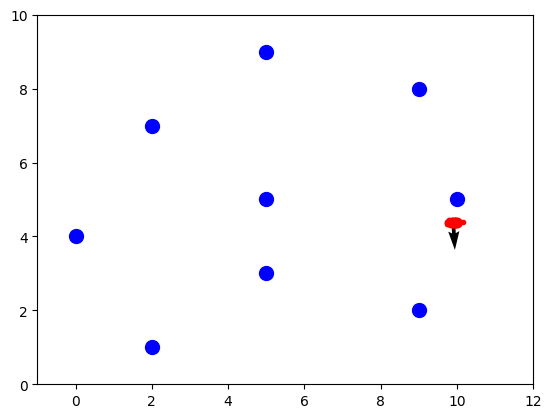

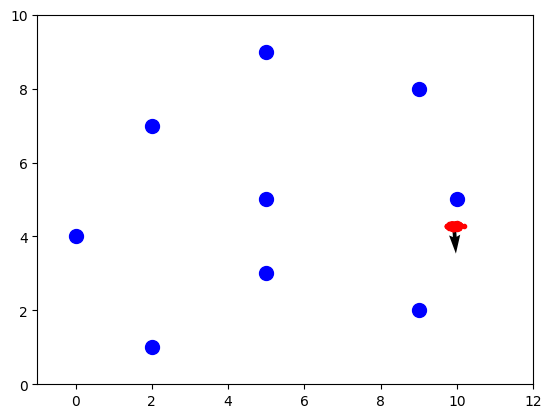

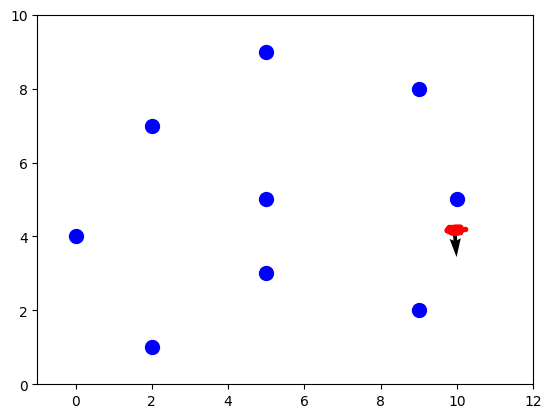

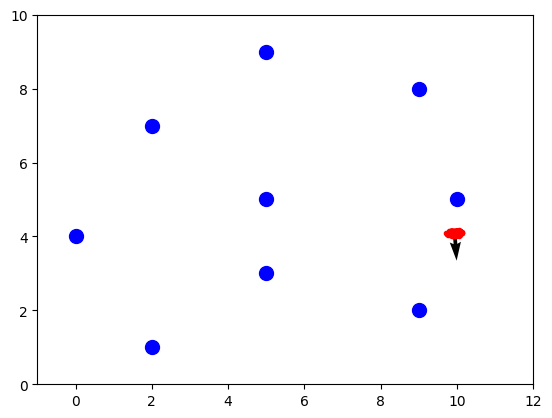

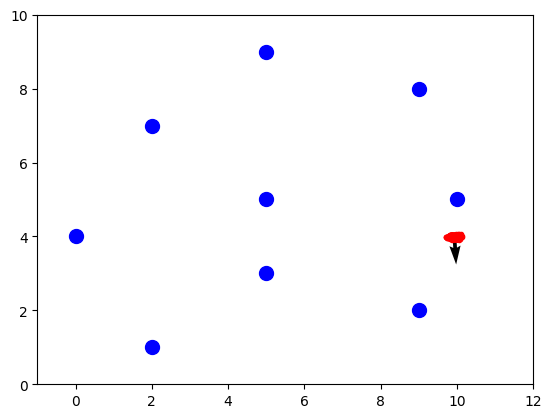

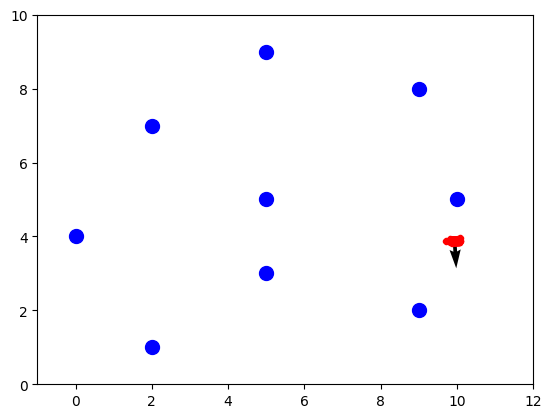

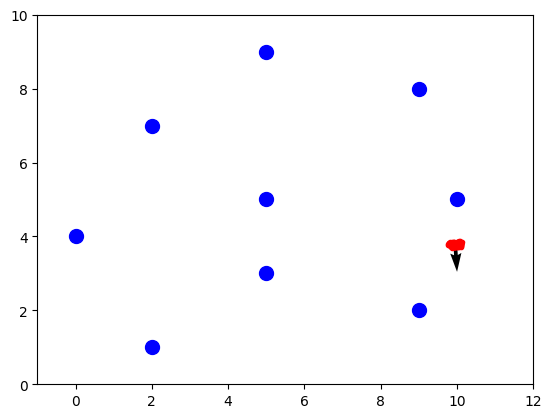

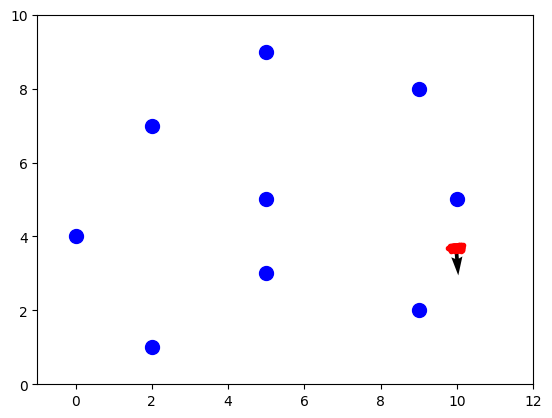

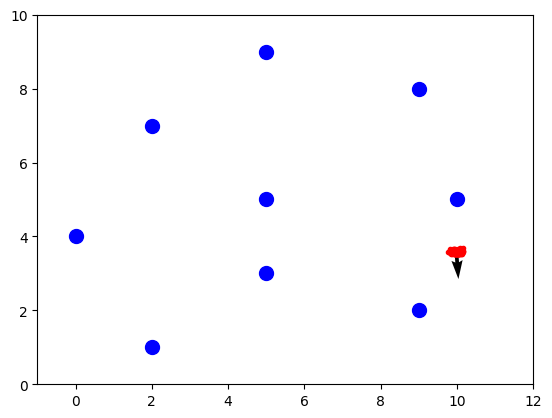

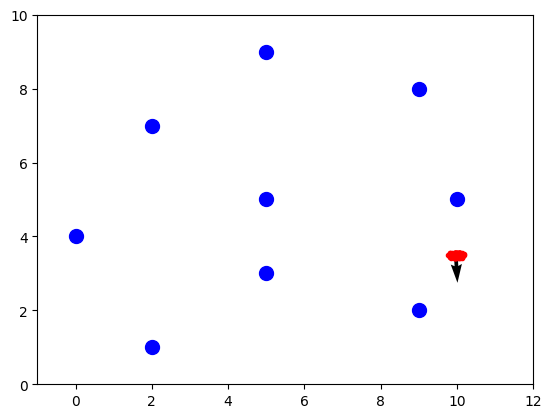

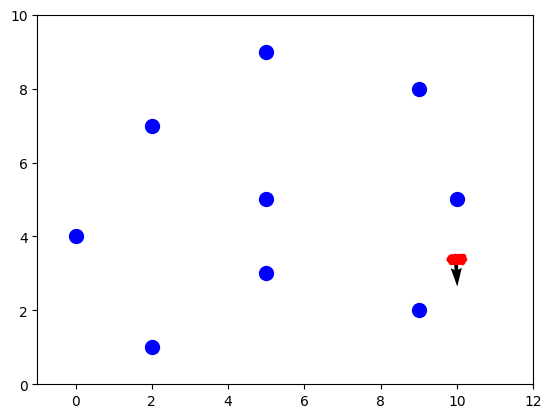

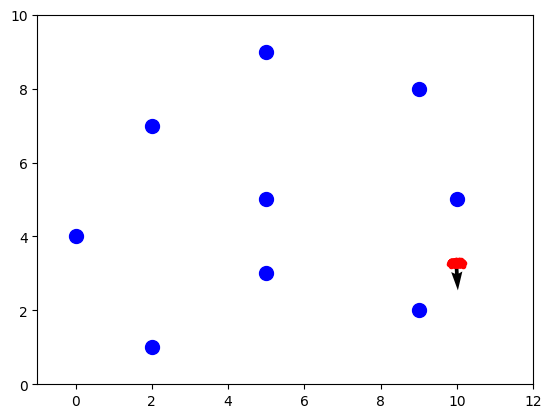

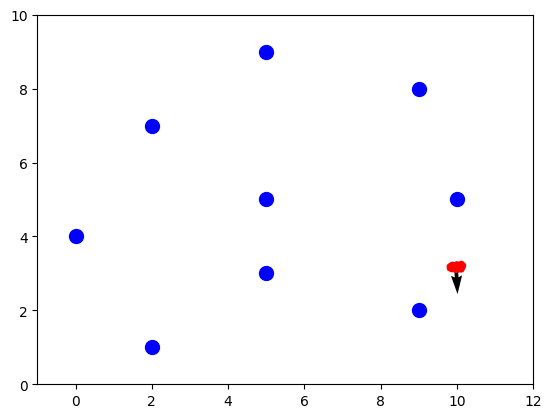

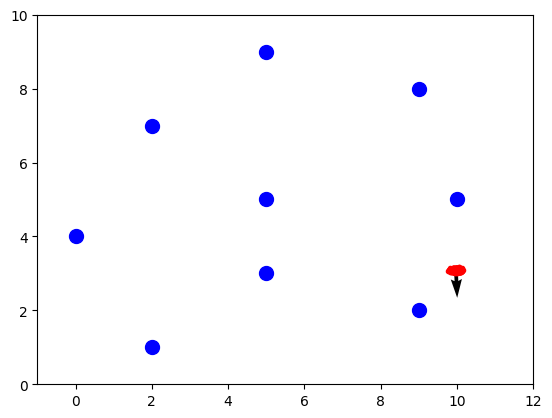

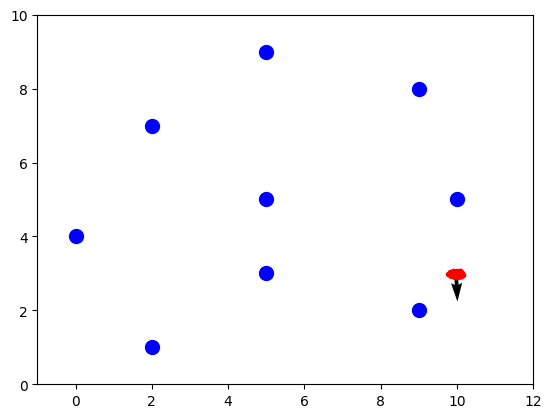

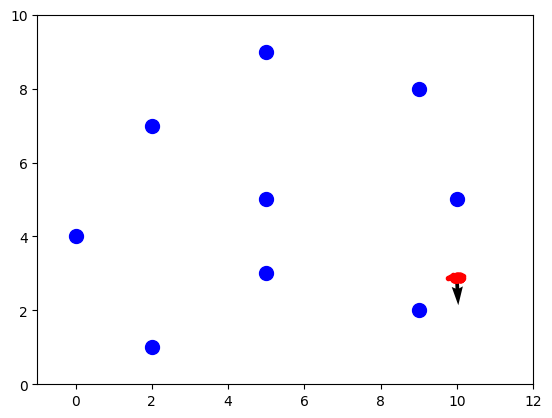

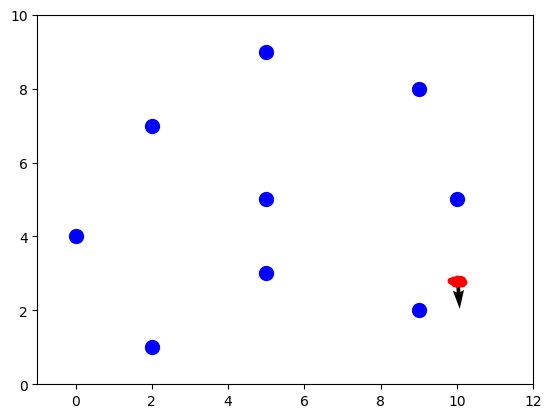

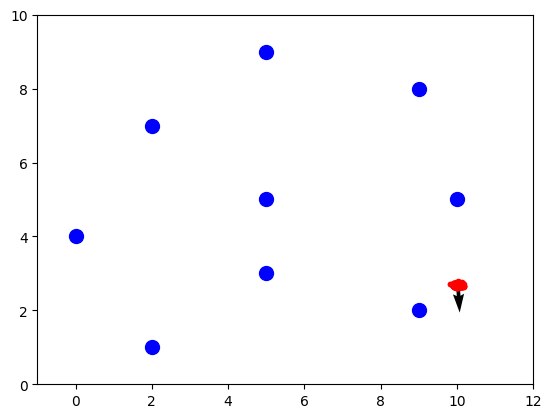

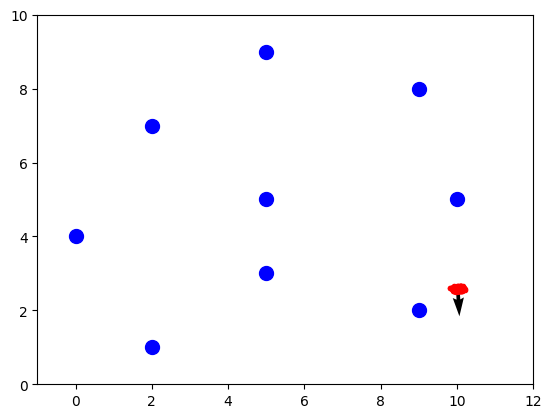

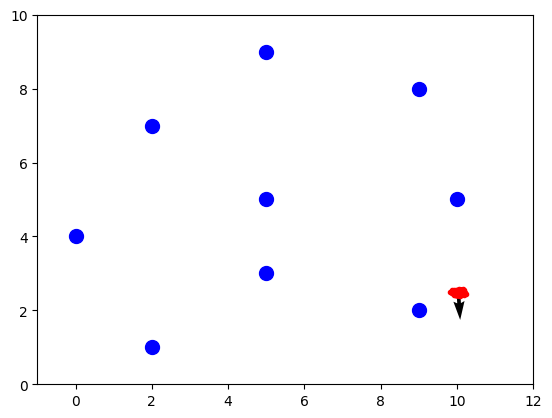

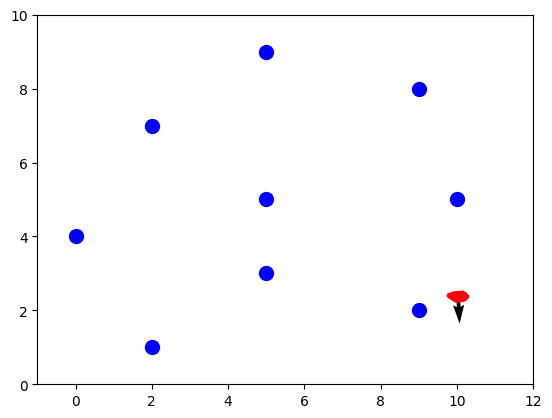

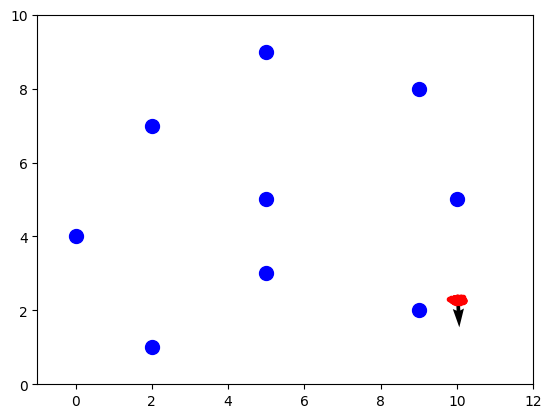

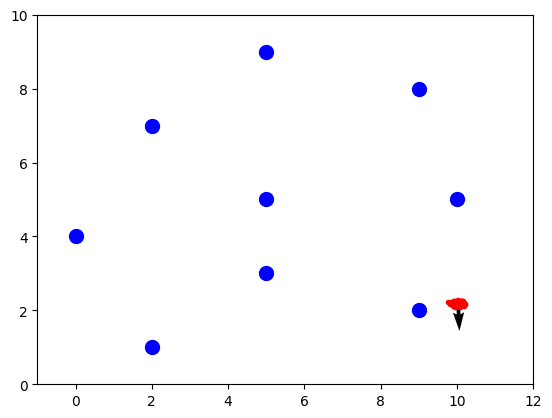

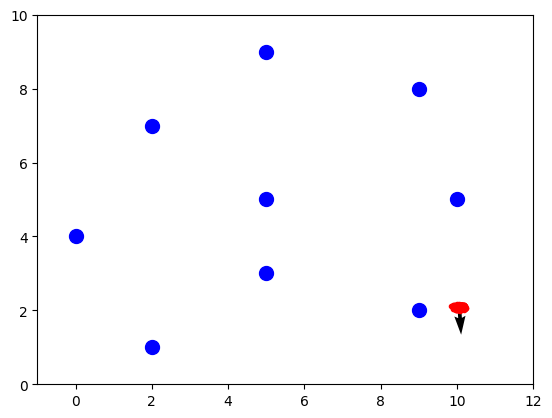

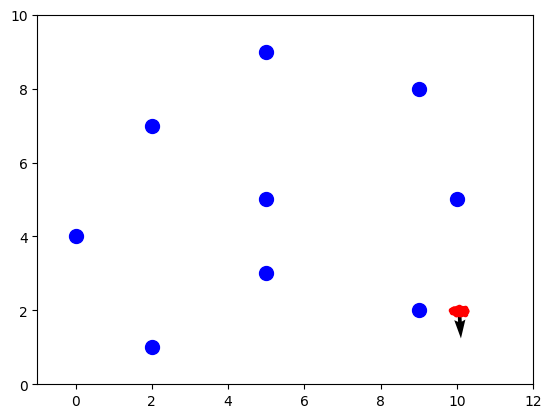

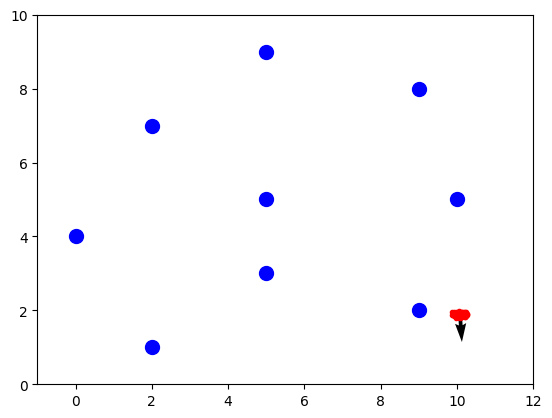

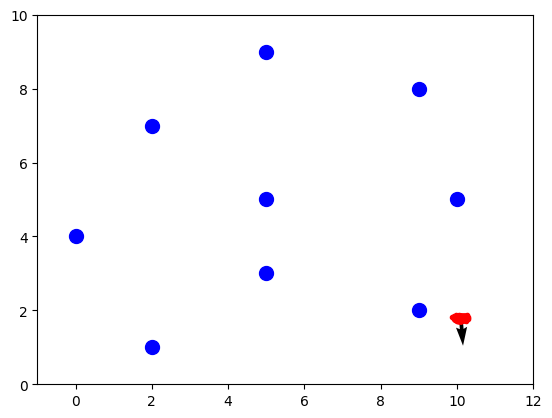

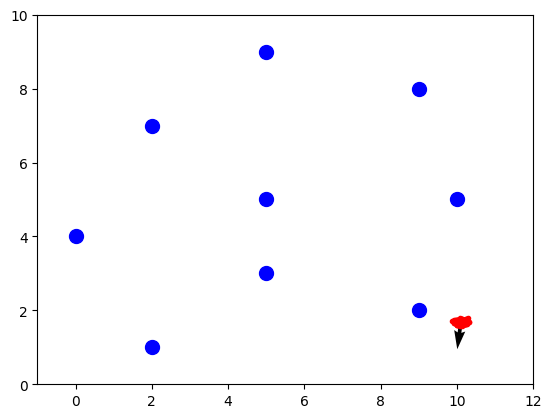

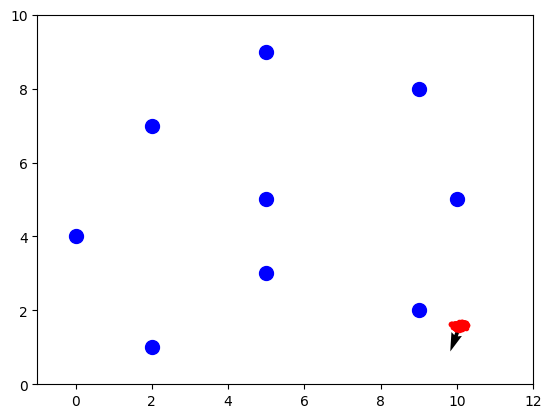

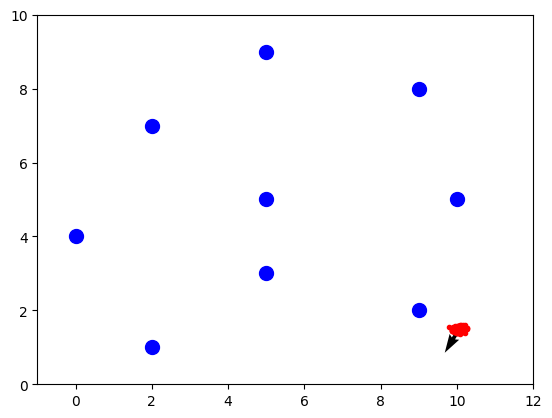

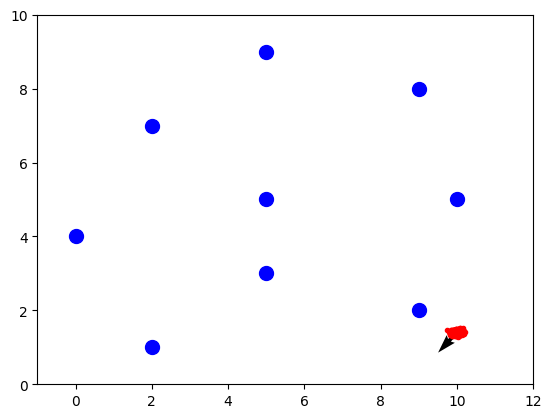

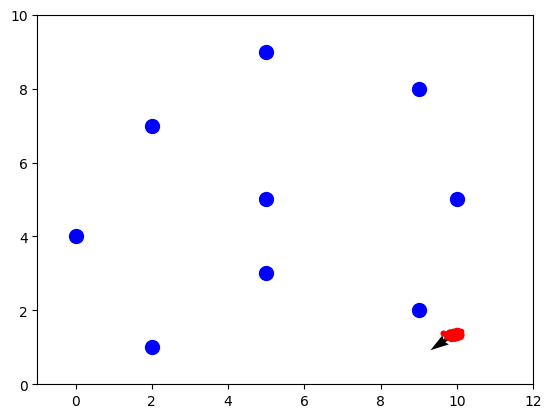

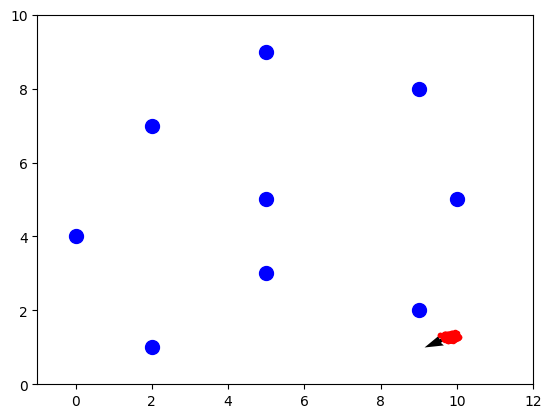

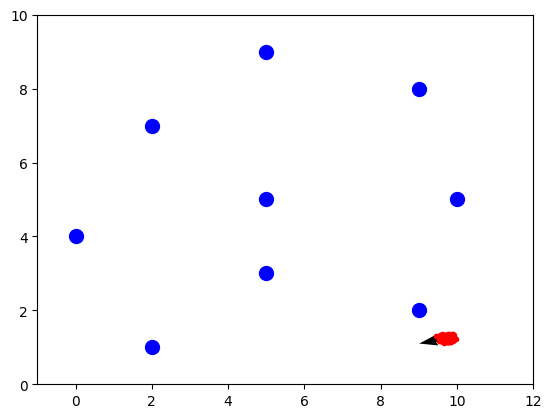

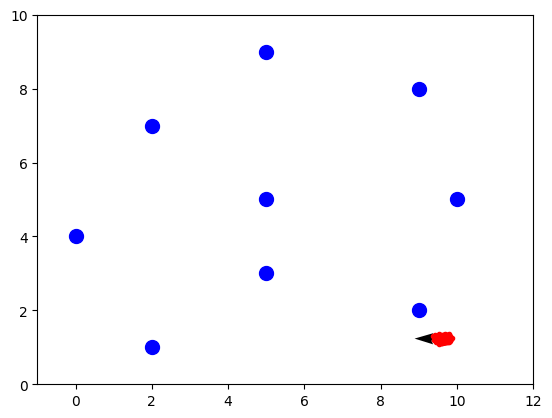

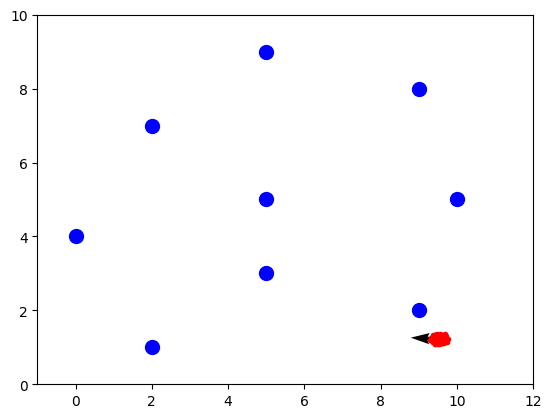

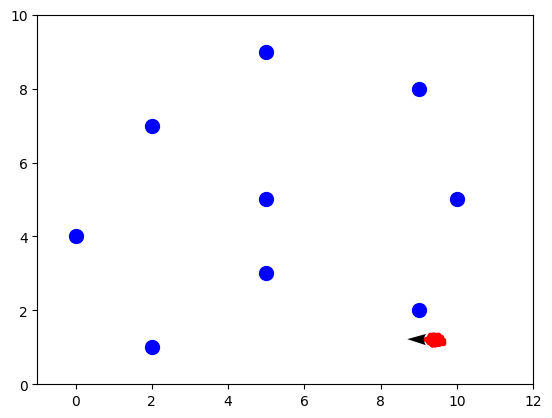

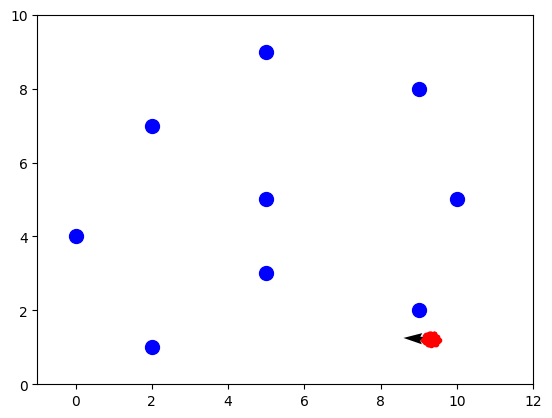

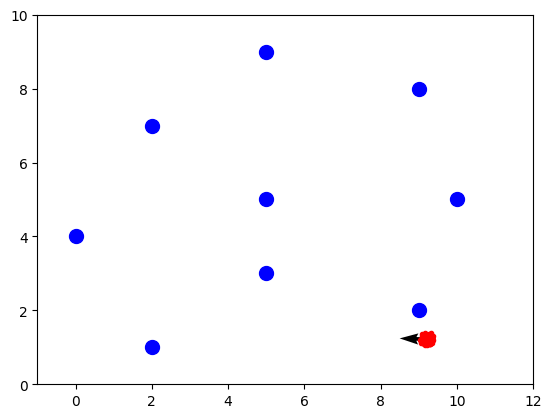

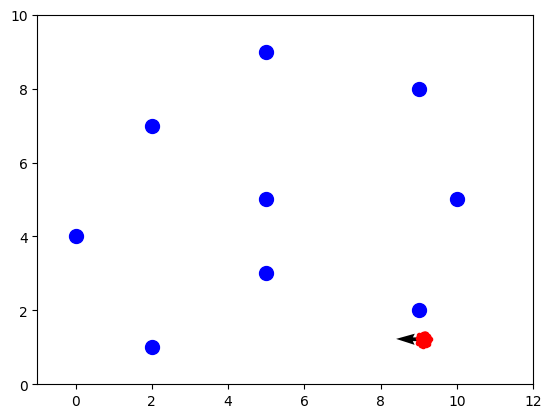

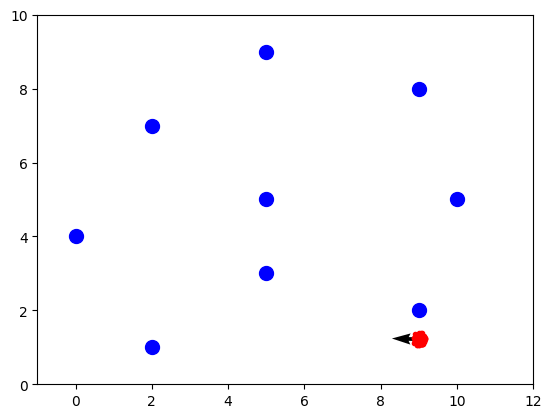

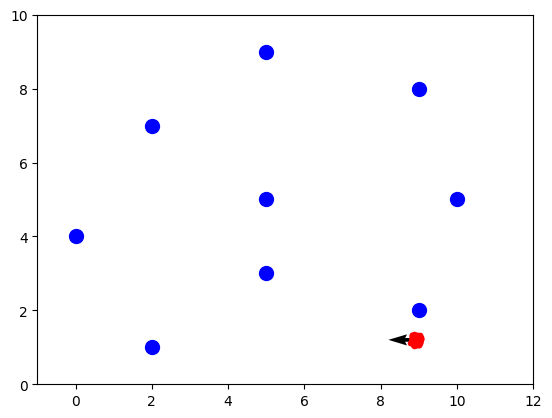

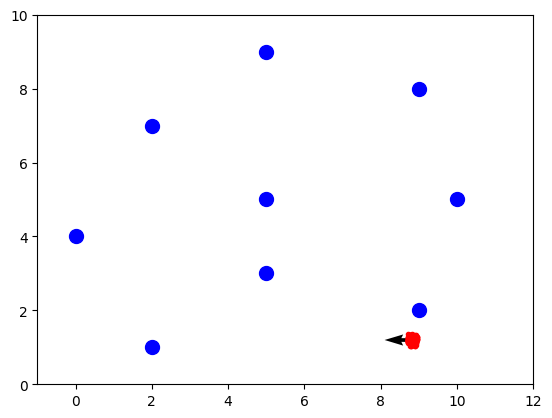

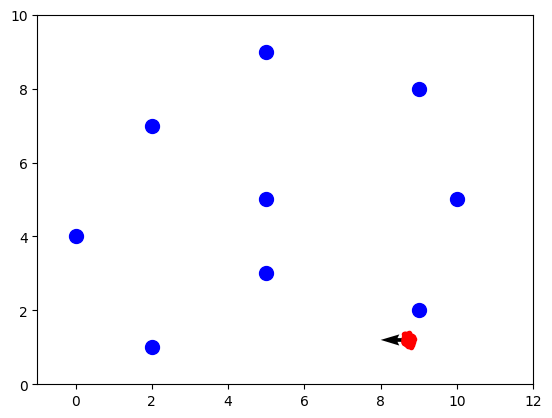

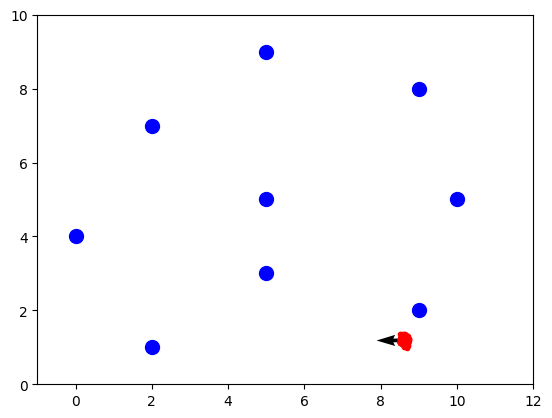

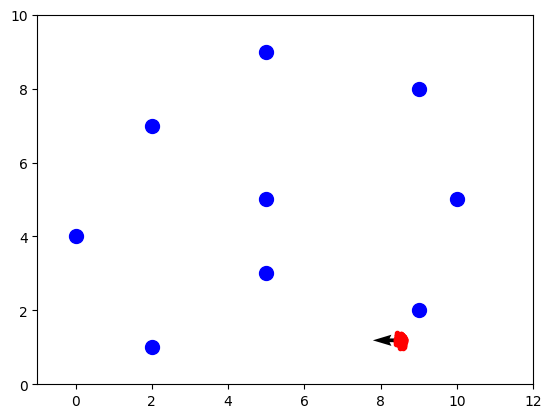

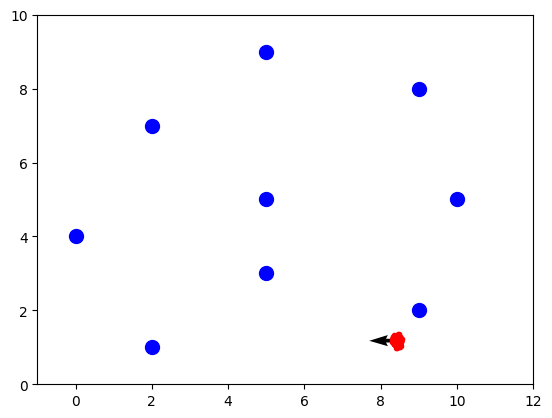

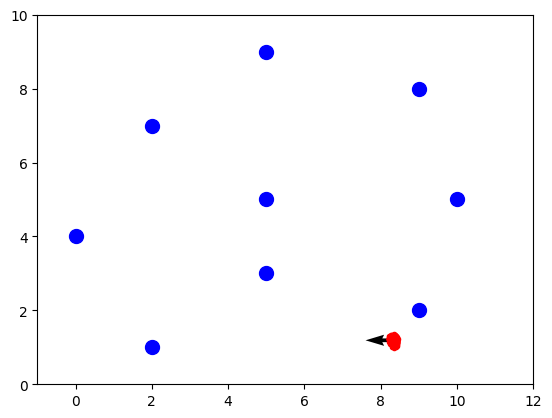

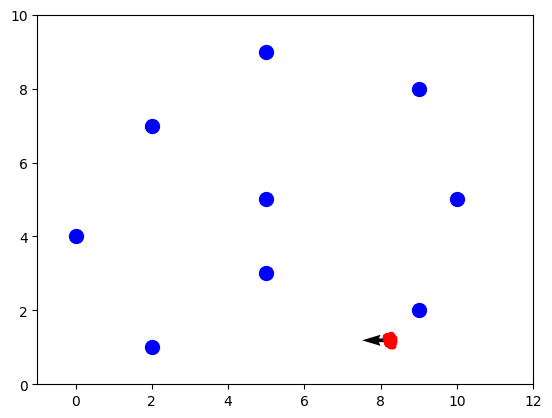

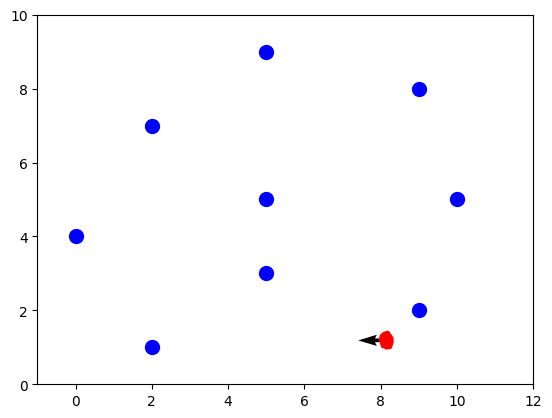

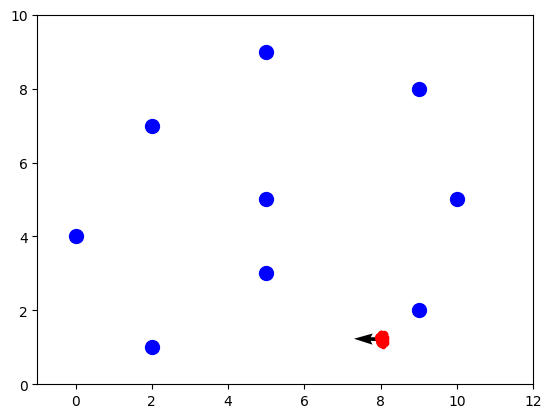

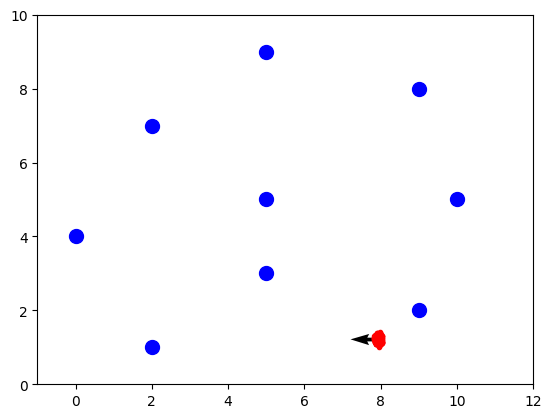

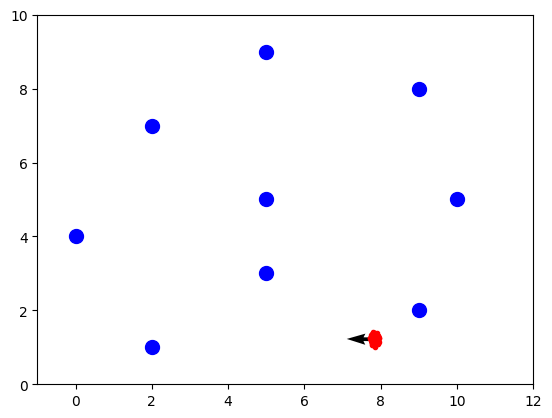

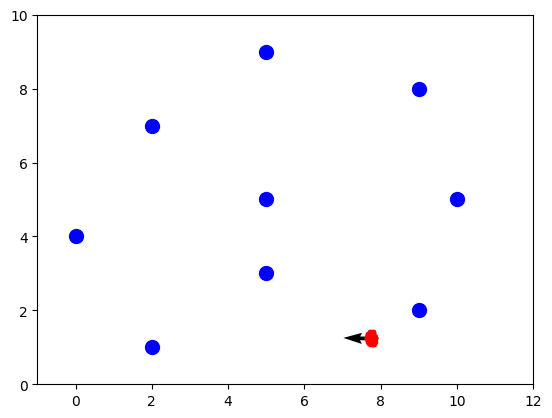

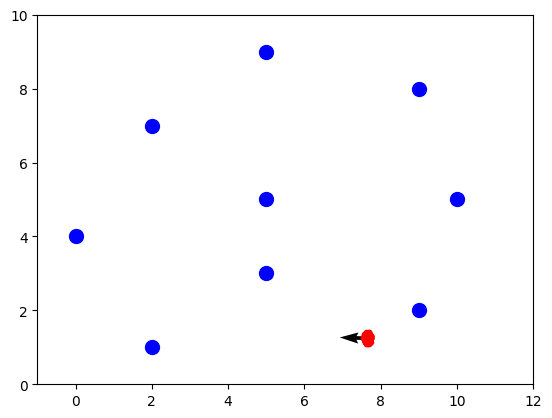

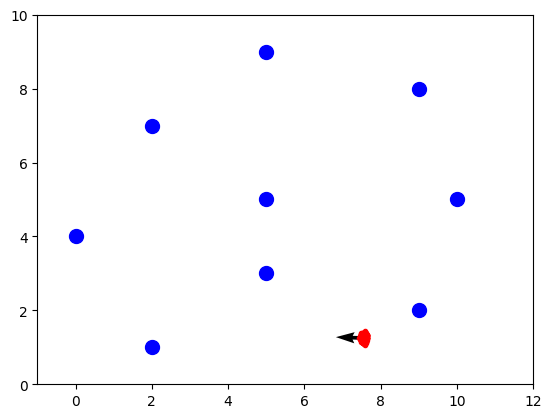

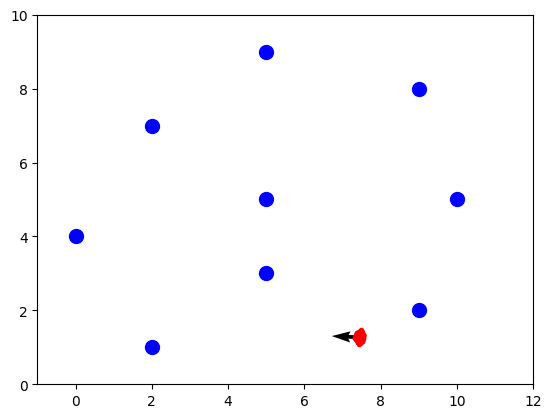

KeyboardInterrupt: 

In [10]:
def main():
         
    print ("Reading landmark positions"); 
    landmarks = read_world("C:pf_framework\code\world.dat")

    print("Reading sensor data"); 
    sensor_readings = read_sensor_data("C:pf_framework\code\sensor_data.dat")

    #initialize the particles
    map_limits = [-1, 12, 0, 10]
    particles = initialize_particles(1000, map_limits)

    #run particle filter
    for timestep in range(int(len(sensor_readings)/2)):

        #plot the current state
        plot_state(particles, landmarks, map_limits)

        #predict particles by sampling from motion model with odometry info
        new_particles = sample_motion_model(sensor_readings[timestep,'odometry'], particles)

        #calculate importance weights according to sensor model
        weights = eval_sensor_model(sensor_readings[timestep, 'sensor'], new_particles, landmarks)

        #resample new particle set according to their importance weights
        particles = resample_particles(new_particles, weights)

    plt.show('hold')

if __name__ == "__main__":
    main()
